<a href="https://colab.research.google.com/github/anika078/CAI5107_ML_project_updated/blob/main/code/ML_DT_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Controlvs PD Dataset

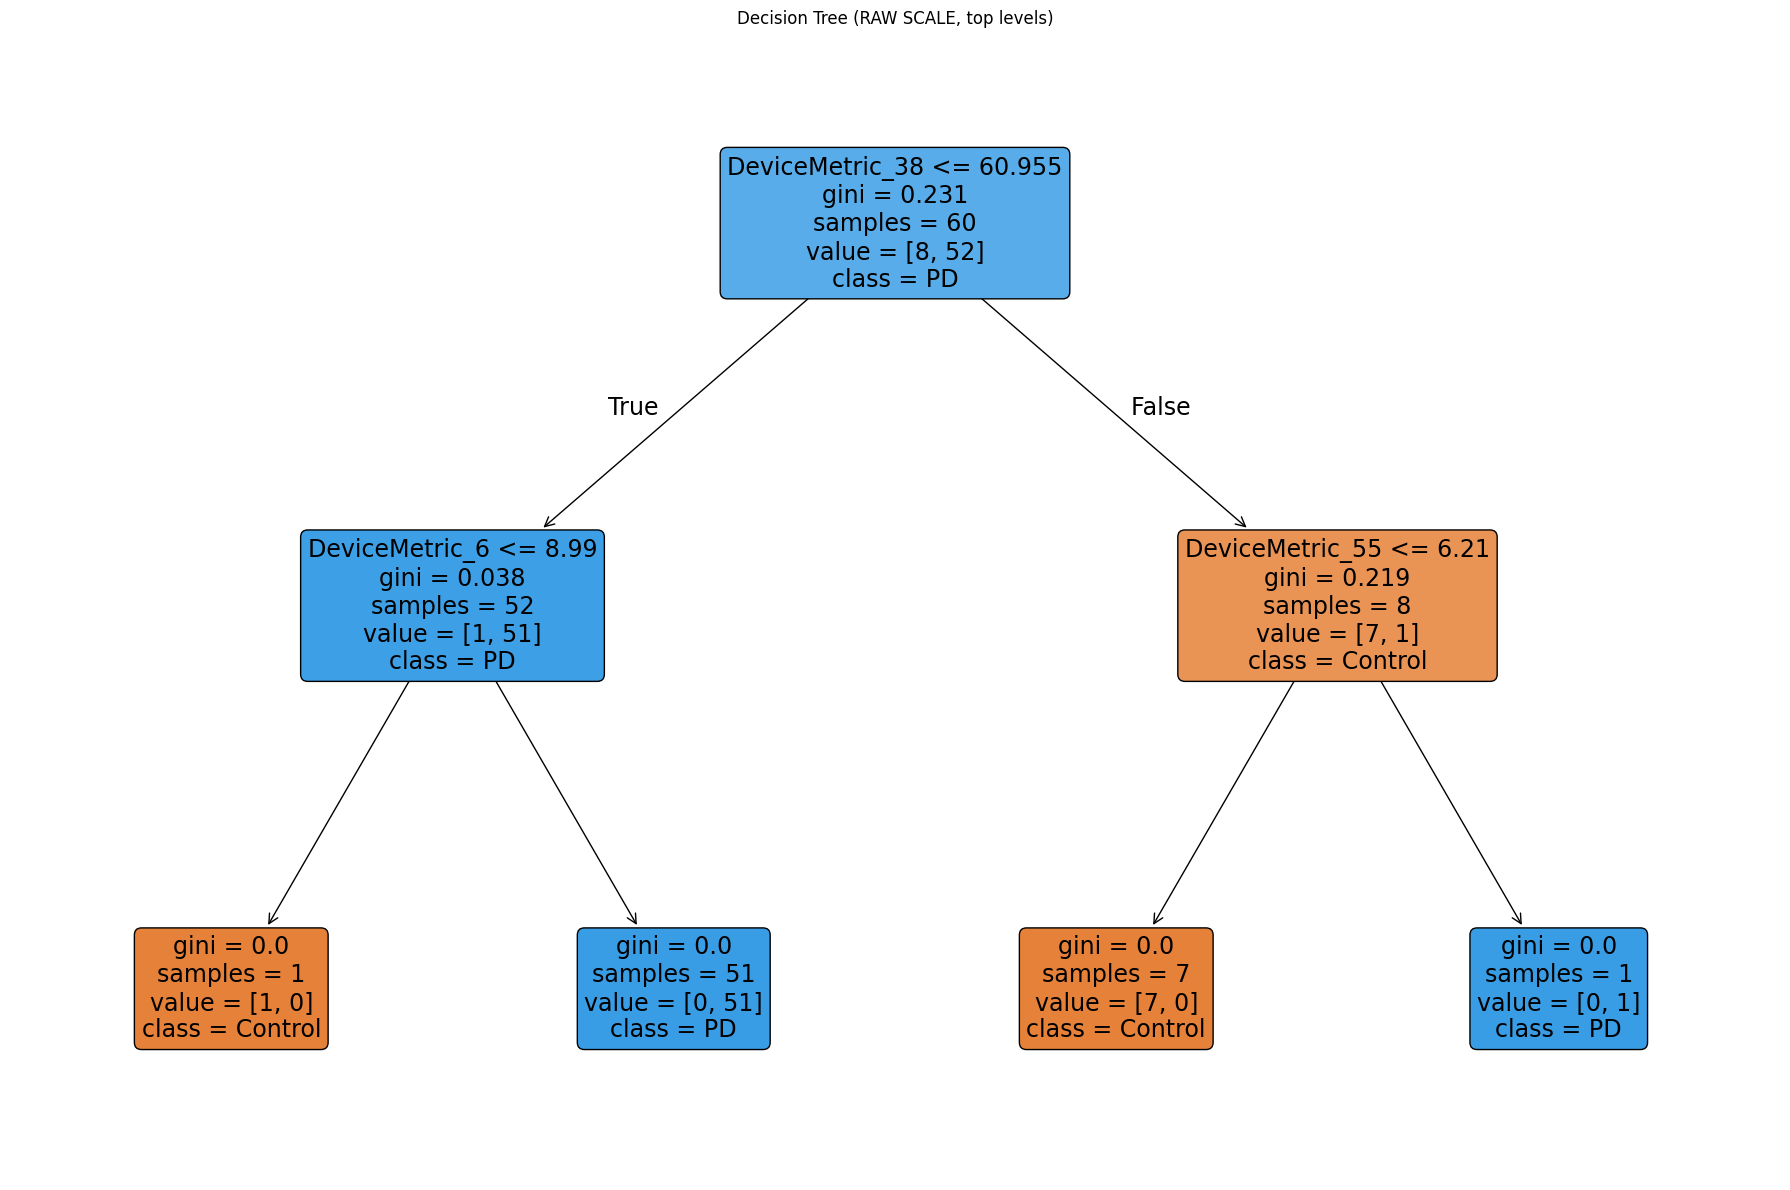

|--- DeviceMetric_38 <= 60.95
|   |--- DeviceMetric_6 <= 8.99
|   |   |--- class: 0
|   |--- DeviceMetric_6 >  8.99
|   |   |--- class: 1
|--- DeviceMetric_38 >  60.95
|   |--- DeviceMetric_55 <= 6.21
|   |   |--- class: 0
|   |--- DeviceMetric_55 >  6.21
|   |   |--- class: 1


=== Classification metrics (TEST) ===
Accuracy : 0.962
Precision: 1.000
Recall   : 0.955
F1-score : 0.977
AUROC    : 0.977
PR-AUC   : 0.993

              precision    recall  f1-score   support

     Control       0.80      1.00      0.89         4
          PD       1.00      0.95      0.98        22

    accuracy                           0.96        26
   macro avg       0.90      0.98      0.93        26
weighted avg       0.97      0.96      0.96        26



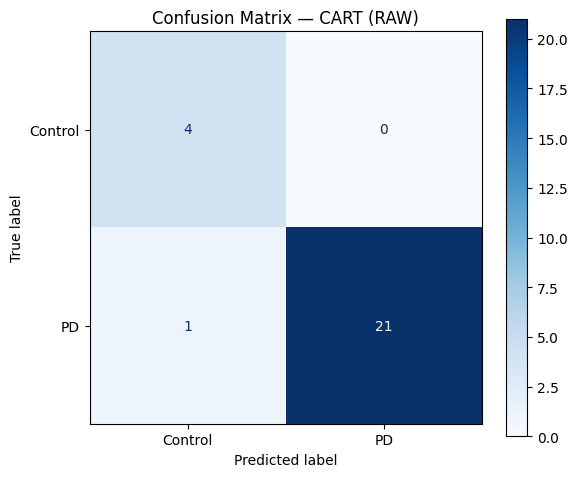

<Figure size 600x500 with 0 Axes>

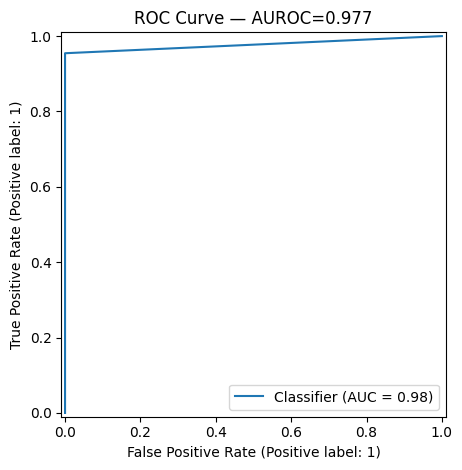

<Figure size 600x500 with 0 Axes>

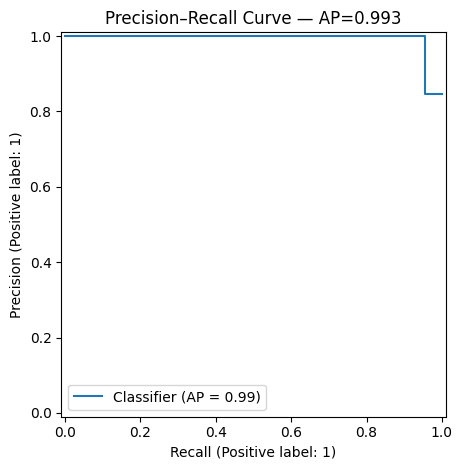

In [9]:

# PD vs Control CART

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
)


IN_PATH           = "/content/Parkinsons_vs_Control_Dataset.csv"
RANDOM_STATE      = 42
TEST_SIZE         = 0.30
ROW_NULL_MAX_FRAC = 0.30
PLOT_MAX_DEPTH    = 4


FEATURE_NAME_MAP = {
    # "DeviceMetric_38": "First Point Distance",
    # "DeviceMetric_6" : "First→Last Point Distance",
    # "DeviceMetric_55": "Some Other Distance",
}


# Load & start from UniqueID==1

df = pd.read_csv(IN_PATH)
df.columns = df.columns.str.strip()
id_col, stage_col = df.columns[0], df.columns[1]

id_numeric = pd.to_numeric(df[id_col], errors="coerce")
first_idx = id_numeric.index[id_numeric == 1].tolist()
if not first_idx:
    raise ValueError(f"Could not find a row with {id_col} == 1.")
df = df.iloc[first_idx[0]:].copy()
df.rename(columns={id_col: "UniqueID", stage_col: "Stage"}, inplace=True)


# Target y: PD(>0)=1, Control(0)=0

df["Stage"] = df["Stage"].astype(str).str.strip()
StageNum = pd.to_numeric(df["Stage"], errors="coerce")
df = df.loc[StageNum.notna()].copy()
StageNum = StageNum.loc[df.index]
y = (StageNum > 0).astype(int)


# Features: DeviceMetric_1..DeviceMetric_57

pattern = re.compile(r"^DeviceMetrics?_([1-9]\d*)$")
feat_pairs = []
for c in df.columns:
    m = pattern.match(c)
    if m:
        k = int(m.group(1))
        if 1 <= k <= 57:
            feat_pairs.append((k, c))
feature_cols = [c for _, c in sorted(feat_pairs)]
if not feature_cols:
    raise ValueError("No DeviceMetric_1..DeviceMetric_57 columns found.")

X = df[feature_cols].apply(pd.to_numeric, errors="coerce")

# Drop rows that are too incomplete though we don't have any null column
row_na_frac = X.isna().mean(axis=1)
keep_mask = row_na_frac <= ROW_NULL_MAX_FRAC
X = X.loc[keep_mask].copy()
y = y.loc[keep_mask].copy()


# Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)


# RAW-scale CART

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", DecisionTreeClassifier(
        criterion="gini",
        splitter="best",
        random_state=RANDOM_STATE
    )),
])
pipe.fit(X_train, y_train)


# Plot: Tree (top levels)

plot_feature_names = [FEATURE_NAME_MAP.get(c, c) for c in feature_cols]
plt.figure(figsize=(18, 12))
plot_tree(
    pipe.named_steps["clf"],
    feature_names=plot_feature_names,
    class_names=["Control", "PD"],
    filled=True,
    rounded=True,
    impurity=True,
    proportion=False,
    max_depth=PLOT_MAX_DEPTH
)
plt.title("Decision Tree (RAW SCALE, top levels)")
plt.tight_layout()
plt.savefig("cart_tree_rawscale.png", dpi=300, bbox_inches="tight")
plt.show()

# Also print readable rules with raw thresholds
print(export_text(pipe.named_steps["clf"], feature_names=list(feature_cols), max_depth=PLOT_MAX_DEPTH))


# Metrics Accuracy, Precision, Recall, F1, AUROC

y_pred  = pipe.predict(X_test)
proba   = pipe.predict_proba(X_test)
pos_idx = list(pipe.named_steps["clf"].classes_).index(1)
y_proba = proba[:, pos_idx]  # PD probability

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auroc = roc_auc_score(y_test, y_proba)
ap    = average_precision_score(y_test, y_proba)  # PR-AUC (average precision)

print("\n=== Classification metrics (TEST) ===")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"AUROC    : {auroc:.3f}")
print(f"PR-AUC   : {ap:.3f}\n")
print(classification_report(y_test, y_pred, target_names=["Control", "PD"], digits=2, zero_division=0))


# Confusion matrix (BLUE)

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
fig = plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Control", "PD"])
ax = plt.gca()
disp.plot(values_format="d", cmap=plt.cm.Blues, ax=ax)  # BLUE colormap as requested
plt.title("Confusion Matrix — CART (RAW)")
plt.tight_layout()
plt.savefig("cart_confusion_matrix_raw_BLUE.png", dpi=300, bbox_inches="tight")
plt.show()

# ROC curve
plt.figure(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC Curve — AUROC={auroc:.3f}")
plt.tight_layout()
plt.savefig("cart_roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()

# Precision–Recall curve
plt.figure(figsize=(6, 5))
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title(f"Precision–Recall Curve — AP={ap:.3f}")
plt.tight_layout()
plt.savefig("cart_precision_recall_curve.png", dpi=300, bbox_inches="tight")
plt.show()


# K fold Cross Validated Paired t-test

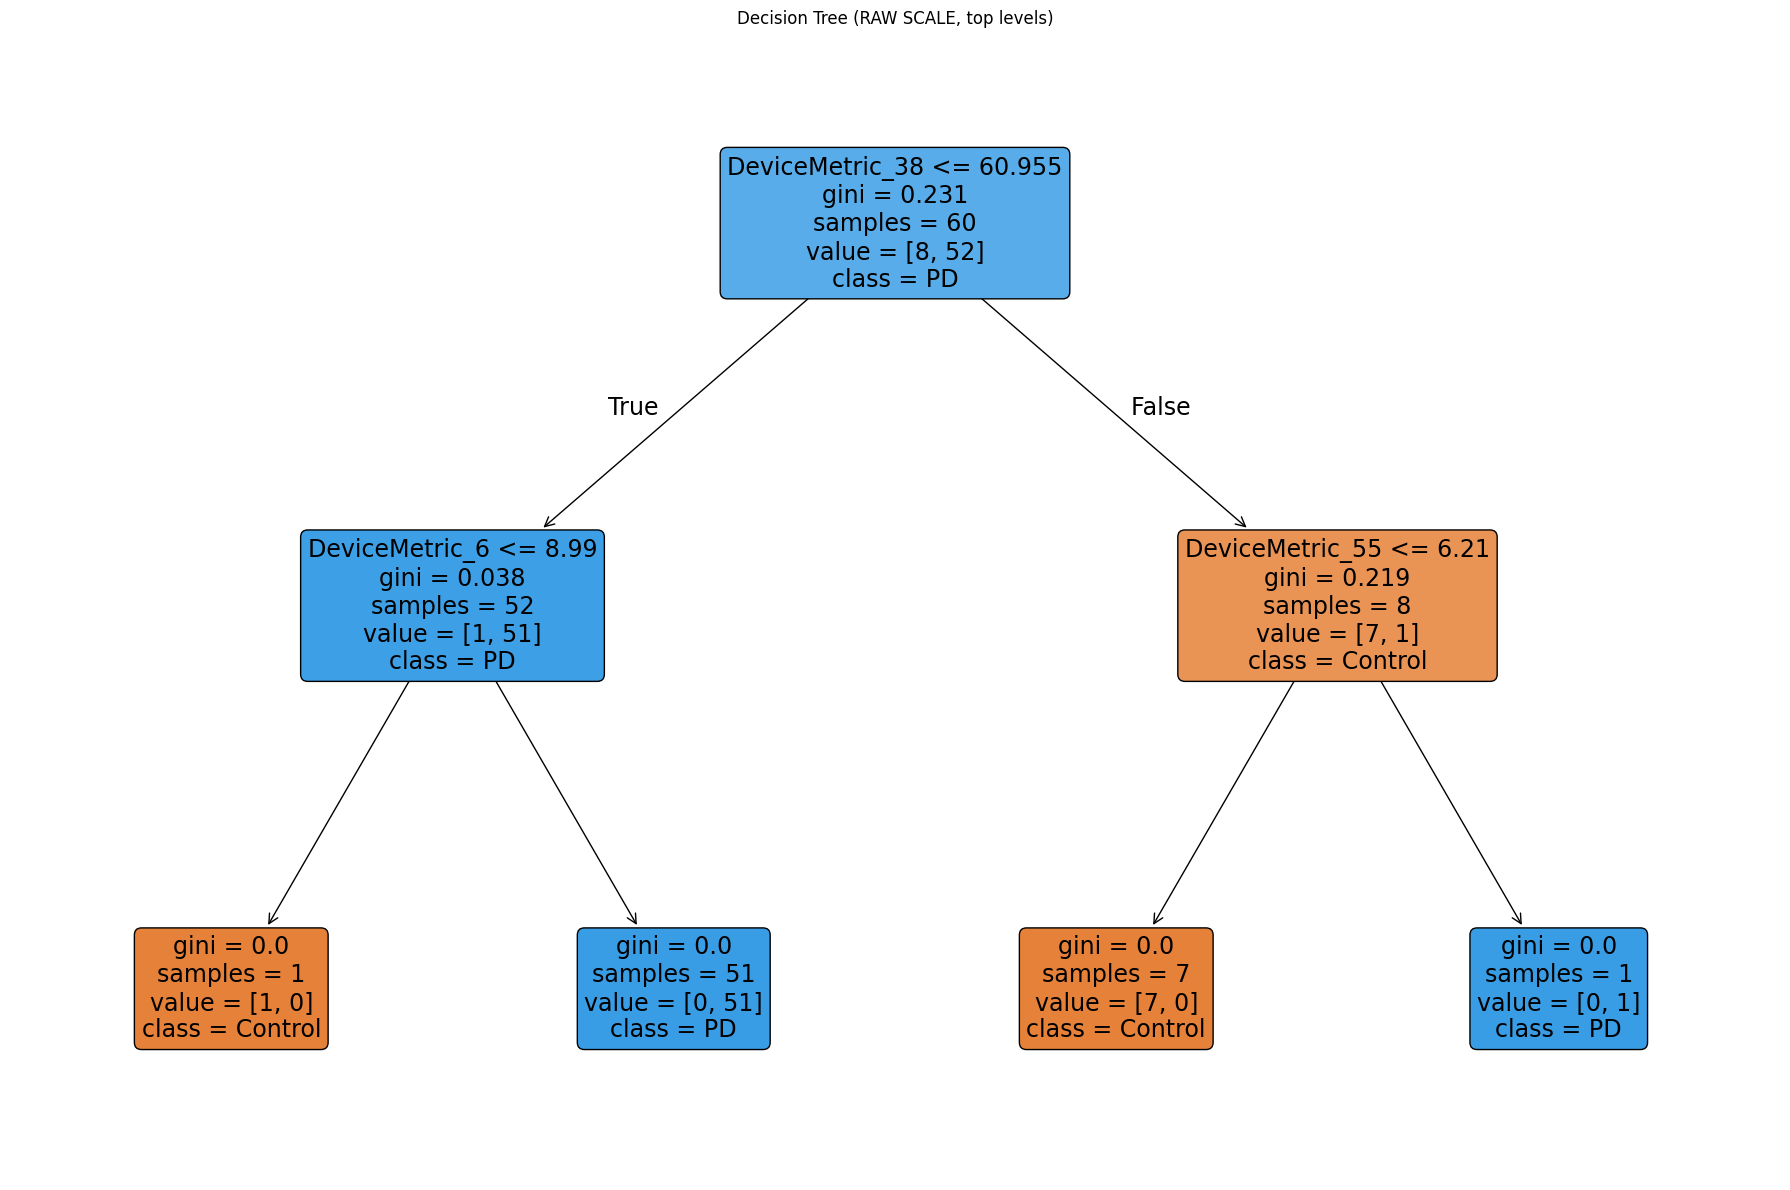

|--- DeviceMetric_38 <= 60.95
|   |--- DeviceMetric_6 <= 8.99
|   |   |--- class: 0
|   |--- DeviceMetric_6 >  8.99
|   |   |--- class: 1
|--- DeviceMetric_38 >  60.95
|   |--- DeviceMetric_55 <= 6.21
|   |   |--- class: 0
|   |--- DeviceMetric_55 >  6.21
|   |   |--- class: 1


=== Classification metrics (TEST) ===
Accuracy : 0.962
Precision: 1.000
Recall   : 0.955
F1-score : 0.977
AUROC    : 0.977
PR-AUC   : 0.993

              precision    recall  f1-score   support

     Control       0.80      1.00      0.89         4
          PD       1.00      0.95      0.98        22

    accuracy                           0.96        26
   macro avg       0.90      0.98      0.93        26
weighted avg       0.97      0.96      0.96        26



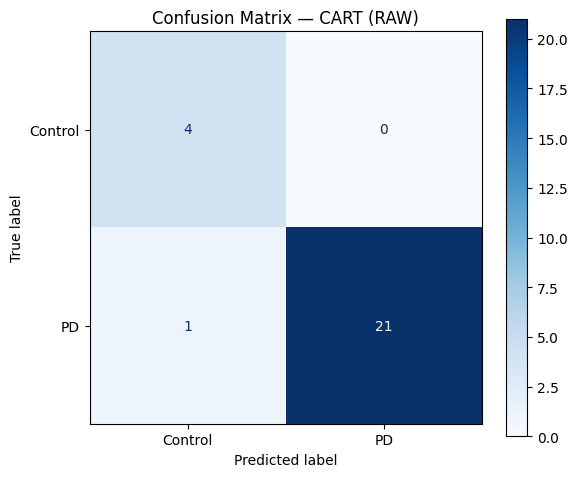

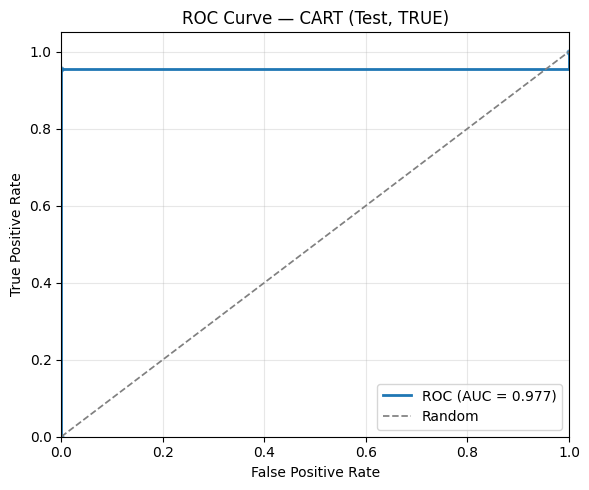

<Figure size 600x500 with 0 Axes>

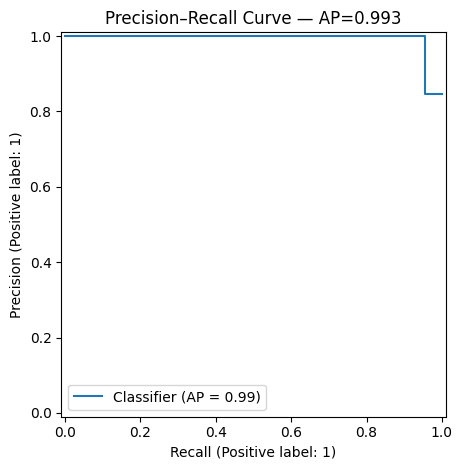


=== Cross-Validation (Stratified K-Fold) ===
Model A: CART (no depth limit)
[Fold 1] AUROC=0.967  AP=0.989  (n=18)
[Fold 2] AUROC=1.000  AP=1.000  (n=17)
[Fold 3] AUROC=1.000  AP=1.000  (n=17)
[Fold 4] AUROC=0.750  AP=0.938  (n=17)
[Fold 5] AUROC=1.000  AP=1.000  (n=17)

Model B: CART (max_depth=4)
[Fold 1] AUROC=0.967  AP=0.989  (n=18)
[Fold 2] AUROC=1.000  AP=1.000  (n=17)
[Fold 3] AUROC=1.000  AP=1.000  (n=17)
[Fold 4] AUROC=0.750  AP=0.938  (n=17)
[Fold 5] AUROC=1.000  AP=1.000  (n=17)

=== Paired t-test (k-fold CV) ===
Hypotheses on AUROC:
Fold AUROC A: [0.967 1.    1.    0.75  1.   ] | mean=0.943 ± 0.109
Fold AUROC B: [0.967 1.    1.    0.75  1.   ] | mean=0.943 ± 0.109
t = 0.000, two-sided p = 1.000, one-sided p (A>B) = 0.500, d = 0.000

Hypotheses on AP (PR-AUC):
Fold AP A: [0.989 1.    1.    0.938 1.   ] | mean=0.985 ± 0.027
Fold AP B: [0.989 1.    1.    0.938 1.   ] | mean=0.985 ± 0.027
t = 0.000, two-sided p = 1.000, one-sided p (A>B) = 0.500, d = 0.000


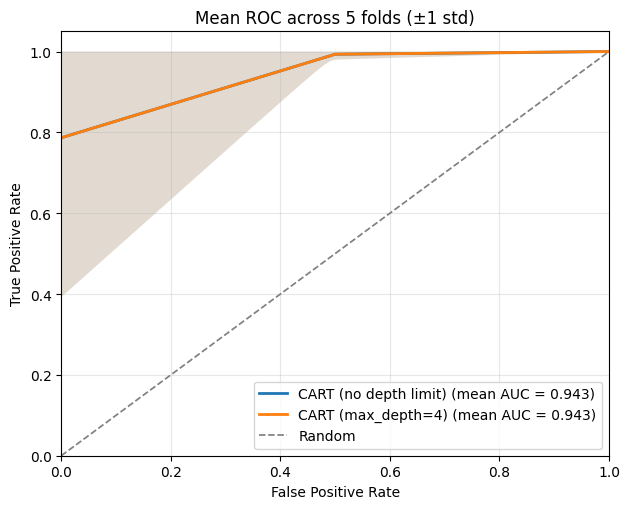

In [11]:

# PD vs Control CART (RAW SCALE) + Train/Test + K-Fold CV + Paired t-test

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, PrecisionRecallDisplay, average_precision_score
)
from scipy.stats import ttest_rel


IN_PATH           = "/content/Parkinsons_vs_Control_Dataset.csv"
RANDOM_STATE      = 42
TEST_SIZE         = 0.30
ROW_NULL_MAX_FRAC = 0.30
PLOT_MAX_DEPTH    = 4
N_SPLITS          = 5  # k in k-fold

FEATURE_NAME_MAP = {
    # "DeviceMetric_38": "First Point Distance",
    # "DeviceMetric_6" : "First→Last Point Distance",
    # "DeviceMetric_55": "Some Other Distance",
}


# Load & start from UniqueID==1

df = pd.read_csv(IN_PATH)
df.columns = df.columns.str.strip()
id_col, stage_col = df.columns[0], df.columns[1]

id_numeric = pd.to_numeric(df[id_col], errors="coerce")
first_idx = id_numeric.index[id_numeric == 1].tolist()
if not first_idx:
    raise ValueError(f"Could not find a row with {id_col} == 1.")
df = df.iloc[first_idx[0]:].copy()
df.rename(columns={id_col: "UniqueID", stage_col: "Stage"}, inplace=True)


# Target y: PD(>0)=1, Control(0)=0

df["Stage"] = df["Stage"].astype(str).str.strip()
StageNum = pd.to_numeric(df["Stage"], errors="coerce")
df = df.loc[StageNum.notna()].copy()
StageNum = StageNum.loc[df.index]
y = (StageNum > 0).astype(int)


# Features: DeviceMetric_1..DeviceMetric_57

pattern = re.compile(r"^DeviceMetrics?_([1-9]\d*)$")
feat_pairs = []
for c in df.columns:
    m = pattern.match(c)
    if m:
        k = int(m.group(1))
        if 1 <= k <= 57:
            feat_pairs.append((k, c))
feature_cols = [c for _, c in sorted(feat_pairs)]
if not feature_cols:
    raise ValueError("No DeviceMetric_1..DeviceMetric_57 columns found.")

X = df[feature_cols].apply(pd.to_numeric, errors="coerce")

row_na_frac = X.isna().mean(axis=1)
keep_mask = row_na_frac <= ROW_NULL_MAX_FRAC
X = X.loc[keep_mask].copy()
y = y.loc[keep_mask].copy()


# Train/Test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", DecisionTreeClassifier(
        criterion="gini",
        splitter="best",
        random_state=RANDOM_STATE
    )),
])
pipe.fit(X_train, y_train)


# Plot: Tree (top levels)

plot_feature_names = [FEATURE_NAME_MAP.get(c, c) for c in feature_cols]
plt.figure(figsize=(18, 12))
plot_tree(
    pipe.named_steps["clf"],
    feature_names=plot_feature_names,
    class_names=["Control", "PD"],
    filled=True,
    rounded=True,
    impurity=True,
    proportion=False,
    max_depth=PLOT_MAX_DEPTH
)
plt.title("Decision Tree (RAW SCALE, top levels)")
plt.tight_layout()
plt.savefig("cart_tree_rawscale.png", dpi=300, bbox_inches="tight")
plt.show()

print(export_text(pipe.named_steps["clf"], feature_names=list(feature_cols), max_depth=PLOT_MAX_DEPTH))


# Single Train/Test Metrics

y_pred  = pipe.predict(X_test)
proba   = pipe.predict_proba(X_test)
pos_idx = list(pipe.named_steps["clf"].classes_).index(1)
y_proba = proba[:, pos_idx]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auroc = roc_auc_score(y_test, y_proba)
ap    = average_precision_score(y_test, y_proba)

print("\n=== Classification metrics (TEST) ===")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"AUROC    : {auroc:.3f}")
print(f"PR-AUC   : {ap:.3f}\n")
print(classification_report(y_test, y_pred, target_names=["Control", "PD"], digits=2, zero_division=0))


# Confusion Matrix & Curves
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
fig = plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Control", "PD"])
ax = plt.gca()
disp.plot(values_format="d", cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix — CART (RAW)")
plt.tight_layout()
plt.savefig("cart_confusion_matrix_raw_BLUE.png", dpi=300, bbox_inches="tight")
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.step(fpr, tpr, where="post", linewidth=2, label=f"ROC (AUC = {roc_auc:.3f})")
plt.scatter(fpr, tpr, s=12, alpha=0.6)
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1.25, color="gray", label="Random")
plt.xlim(0, 1); plt.ylim(0, 1.05)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — CART (Test, TRUE)")
plt.legend(loc="lower right"); plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("cart_roc_curve_true.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(6, 5))
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title(f"Precision–Recall Curve — AP={ap:.3f}")
plt.tight_layout()
plt.savefig("cart_precision_recall_curve.png", dpi=300, bbox_inches="tight")
plt.show()


# K-Fold Cross-Validation + Paired t-test

def build_pipe_a():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", DecisionTreeClassifier(
            criterion="gini",
            splitter="best",
            random_state=RANDOM_STATE
        )),
    ])

def build_pipe_b():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", DecisionTreeClassifier(
            criterion="gini",
            splitter="best",
            max_depth=4,
            random_state=RANDOM_STATE
        )),
    ])

def evaluate_cv(pipe_builder, X, y, n_splits=N_SPLITS, random_state=RANDOM_STATE):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fpr_grid = np.linspace(0, 1, 501)
    all_tpr_on_grid, aucs, aps = [], [], []

    for fold_idx, (tr, te) in enumerate(skf.split(X, y), start=1):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        pipe = pipe_builder()
        pipe.fit(X_tr, y_tr)
        proba = pipe.predict_proba(X_te)
        pos_idx = list(pipe.named_steps["clf"].classes_).index(1)
        y_proba = proba[:, pos_idx]

        fpr, tpr, _ = roc_curve(y_te, y_proba, pos_label=1)
        fold_auc = auc(fpr, tpr)
        fold_ap  = average_precision_score(y_te, y_proba)

        fpr_unique = np.unique(fpr)
        tpr_max = np.array([tpr[fpr == x].max() for x in fpr_unique])
        tpr_on_grid = np.interp(fpr_grid, fpr_unique, tpr_max)
        all_tpr_on_grid.append(tpr_on_grid)
        aucs.append(fold_auc)
        aps.append(fold_ap)

        print(f"[Fold {fold_idx}] AUROC={fold_auc:.3f}  AP={fold_ap:.3f}  (n={len(y_te)})")

    all_tpr_on_grid = np.vstack(all_tpr_on_grid)
    mean_tpr = all_tpr_on_grid.mean(axis=0)
    std_tpr  = all_tpr_on_grid.std(axis=0)
    return {"auroc": aucs, "ap": aps, "fpr_grid": fpr_grid, "mean_tpr": mean_tpr, "std_tpr": std_tpr}

print("\n=== Cross-Validation (Stratified K-Fold) ===")
print("Model A: CART (no depth limit)")
res_a = evaluate_cv(build_pipe_a, X, y)
print("\nModel B: CART (max_depth=4)")
res_b = evaluate_cv(build_pipe_b, X, y)

aucs_a, aucs_b = np.array(res_a["auroc"]), np.array(res_b["auroc"])
aps_a, aps_b   = np.array(res_a["ap"]),    np.array(res_b["ap"])

t_auc, p_auc_two = ttest_rel(aucs_a, aucs_b)
t_ap,  p_ap_two  = ttest_rel(aps_a,  aps_b)


if np.isnan(t_auc): t_auc, p_auc_two = 0.0, 1.0
if np.isnan(t_ap):  t_ap,  p_ap_two  = 0.0, 1.0

def one_sided_p(two_sided_p, t_stat):
    return two_sided_p / 2 if t_stat > 0 else 1 - (two_sided_p / 2)

p_auc_one_plus = one_sided_p(p_auc_two, t_auc)
p_ap_one_plus  = one_sided_p(p_ap_two,  t_ap)

def paired_cohens_d(a, b):
    diff = a - b
    return 0.0 if np.allclose(diff, 0) else diff.mean() / (diff.std(ddof=1) + 1e-12)

d_auc, d_ap = paired_cohens_d(aucs_a, aucs_b), paired_cohens_d(aps_a, aps_b)

print("\n=== Paired t-test (k-fold CV) ===")
print("Hypotheses on AUROC:")
print(f"Fold AUROC A: {np.round(aucs_a, 3)} | mean={aucs_a.mean():.3f} ± {aucs_a.std(ddof=1):.3f}")
print(f"Fold AUROC B: {np.round(aucs_b, 3)} | mean={aucs_b.mean():.3f} ± {aucs_b.std(ddof=1):.3f}")
print(f"t = {t_auc:.3f}, two-sided p = {p_auc_two:.3f}, one-sided p (A>B) = {p_auc_one_plus:.3f}, d = {d_auc:.3f}")

print("\nHypotheses on AP (PR-AUC):")
print(f"Fold AP A: {np.round(aps_a, 3)} | mean={aps_a.mean():.3f} ± {aps_a.std(ddof=1):.3f}")
print(f"Fold AP B: {np.round(aps_b, 3)} | mean={aps_b.mean():.3f} ± {aps_b.std(ddof=1):.3f}")
print(f"t = {t_ap:.3f}, two-sided p = {p_ap_two:.3f}, one-sided p (A>B) = {p_ap_one_plus:.3f}, d = {d_ap:.3f}")

# --- Mean ROC across folds
plt.figure(figsize=(6.4, 5.2))
for label, res in [("CART (no depth limit)", res_a), ("CART (max_depth=4)", res_b)]:
    fpr_grid, mean_tpr, std_tpr = res["fpr_grid"], res["mean_tpr"], res["std_tpr"]
    mean_auc = np.mean(res["auroc"])
    plt.plot(fpr_grid, mean_tpr, lw=2, label=f"{label} (mean AUC = {mean_auc:.3f})")
    plt.fill_between(fpr_grid,
                     np.clip(mean_tpr - std_tpr, 0, 1),
                     np.clip(mean_tpr + std_tpr, 0, 1),
                     alpha=0.15)
plt.plot([0,1],[0,1],"--",lw=1.25,color="gray",label="Random")
plt.xlim(0,1); plt.ylim(0,1.05)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"Mean ROC across {N_SPLITS} folds (±1 std)")
plt.legend(loc="lower right"); plt.grid(alpha=0.3)
plt.tight_layout(); plt.savefig("cv_mean_roc.png", dpi=300, bbox_inches="tight")
plt.show()


Categorized tablet based assessments PD vs Control

Total samples: 86 | Features: 57
Target distribution: {1: 74, 0: 12}

Feature counts by category:
  executive function: 4 features
  memory: 3 features
  motor: 39 features
  speech: 11 features


CATEGORY: EXECUTIVE FUNCTION
Using 4 features from 'executive function' category

--- Test Set Metrics ---
Accuracy : 0.8846
Precision: 0.9130
Recall   : 0.9545
F1-score : 0.9333
AUROC    : 0.7273

Classification Report:
              precision    recall  f1-score   support

     Control      0.667     0.500     0.571         4
          PD      0.913     0.955     0.933        22

    accuracy                          0.885        26
   macro avg      0.790     0.727     0.752        26
weighted avg      0.875     0.885     0.878        26

Confusion Matrix:
                 Pred: Control  Pred: PD
Actual: Control              2         2
Actual: PD                   1        21


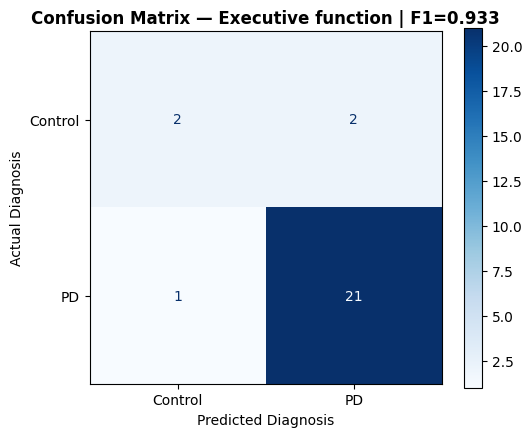

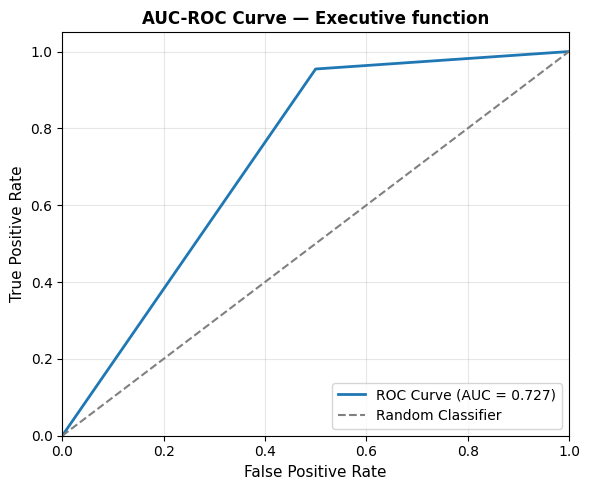

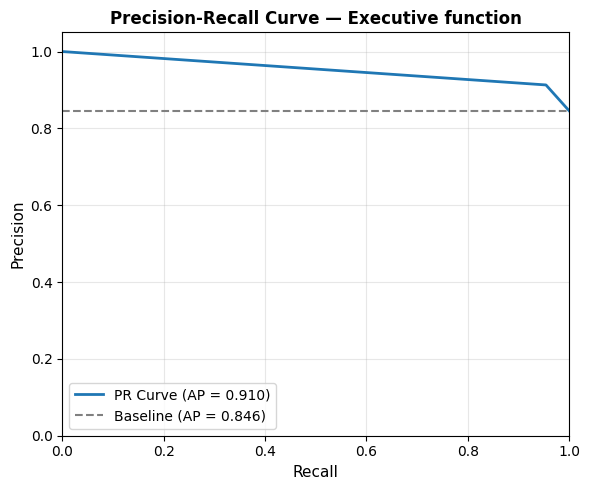



CATEGORY: MEMORY
Using 3 features from 'memory' category

--- Test Set Metrics ---
Accuracy : 0.8077
Precision: 0.9048
Recall   : 0.8636
F1-score : 0.8837
AUROC    : 0.6818

Classification Report:
              precision    recall  f1-score   support

     Control      0.400     0.500     0.444         4
          PD      0.905     0.864     0.884        22

    accuracy                          0.808        26
   macro avg      0.652     0.682     0.664        26
weighted avg      0.827     0.808     0.816        26

Confusion Matrix:
                 Pred: Control  Pred: PD
Actual: Control              2         2
Actual: PD                   3        19


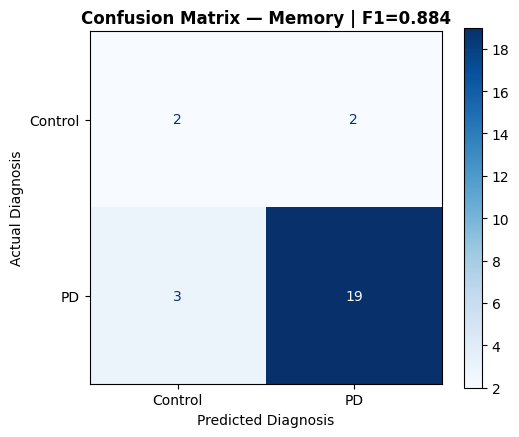

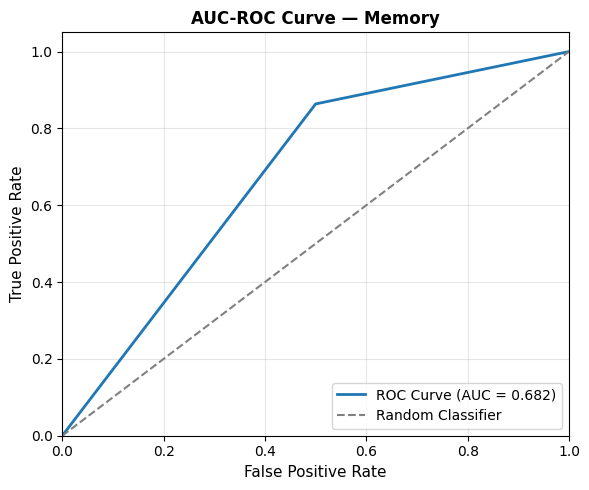

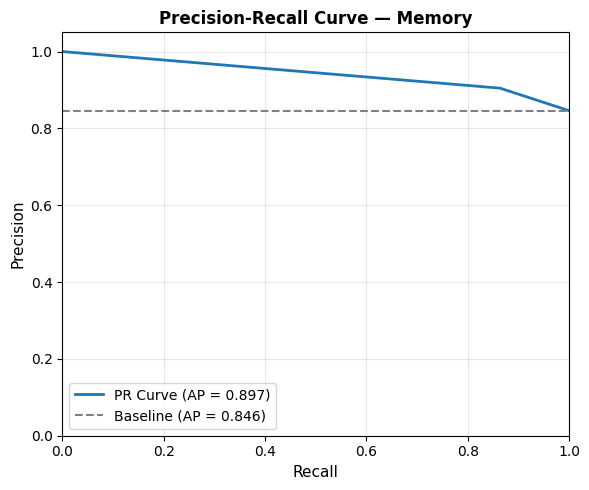



CATEGORY: MOTOR
Using 39 features from 'motor' category

--- Test Set Metrics ---
Accuracy : 0.9615
Precision: 1.0000
Recall   : 0.9545
F1-score : 0.9767
AUROC    : 0.9773

Classification Report:
              precision    recall  f1-score   support

     Control      0.800     1.000     0.889         4
          PD      1.000     0.955     0.977        22

    accuracy                          0.962        26
   macro avg      0.900     0.977     0.933        26
weighted avg      0.969     0.962     0.963        26

Confusion Matrix:
                 Pred: Control  Pred: PD
Actual: Control              4         0
Actual: PD                   1        21


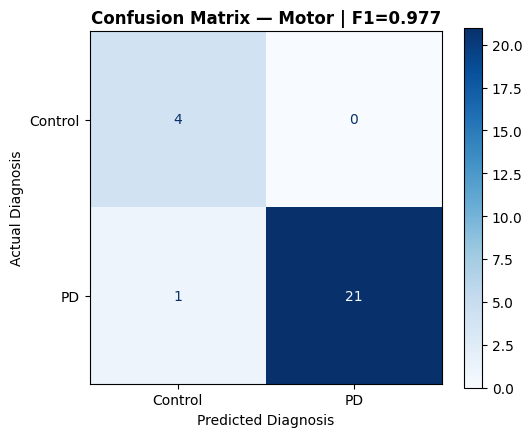

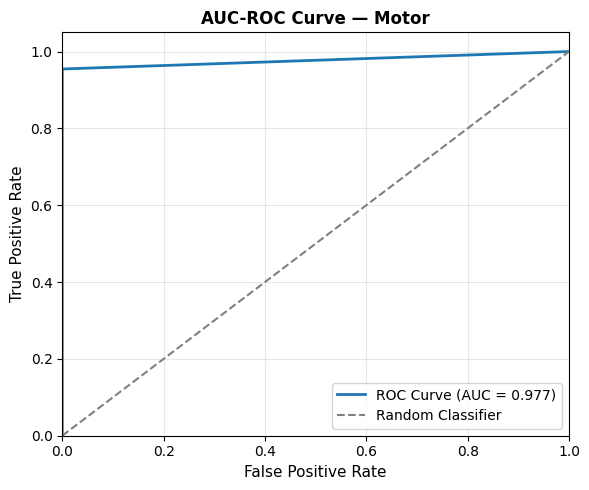

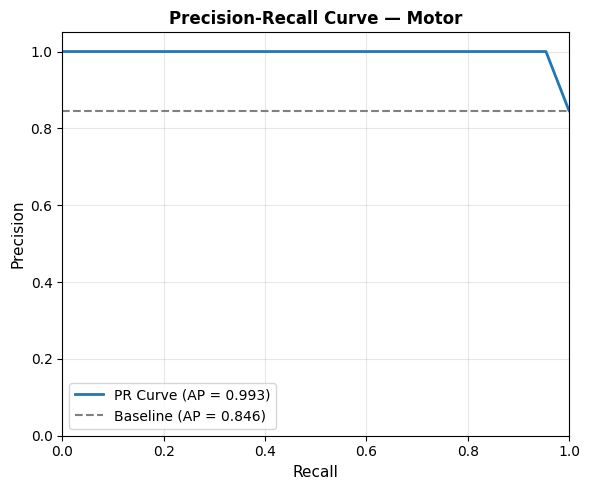



CATEGORY: SPEECH
Using 11 features from 'speech' category

--- Test Set Metrics ---
Accuracy : 0.9231
Precision: 0.9545
Recall   : 0.9545
F1-score : 0.9545
AUROC    : 0.8523

Classification Report:
              precision    recall  f1-score   support

     Control      0.750     0.750     0.750         4
          PD      0.955     0.955     0.955        22

    accuracy                          0.923        26
   macro avg      0.852     0.852     0.852        26
weighted avg      0.923     0.923     0.923        26

Confusion Matrix:
                 Pred: Control  Pred: PD
Actual: Control              3         1
Actual: PD                   1        21


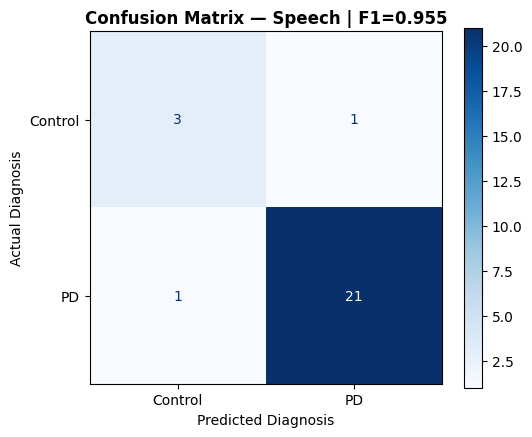

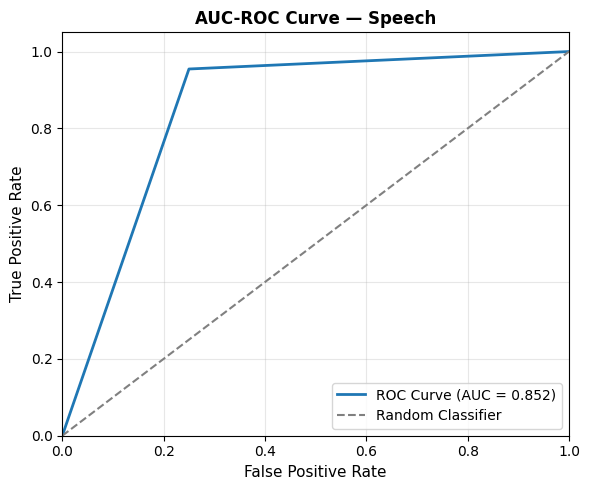

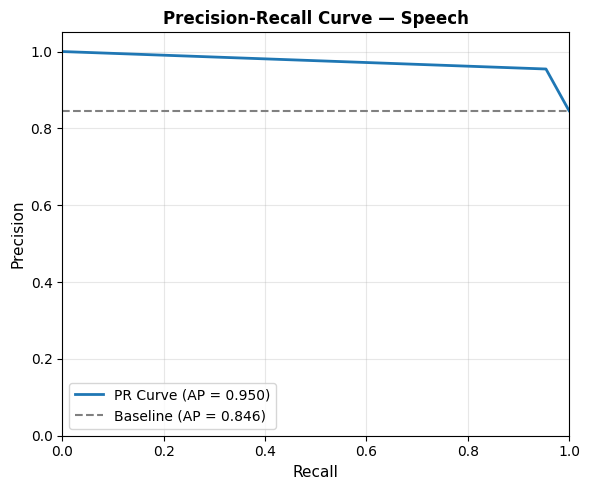



SUMMARY TABLE - ALL CATEGORIES
Assessment/function  Accuracy  Precision  Recall     F1  AUROC
 Executive function    0.8846     0.9130  0.9545 0.9333 0.7273
             Memory    0.8077     0.9048  0.8636 0.8837 0.6818
              Motor    0.9615     1.0000  0.9545 0.9767 0.9773
             Speech    0.9231     0.9545  0.9545 0.9545 0.8523



In [16]:

# Category-wise CART Analysis - COMPREHENSIVE

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve, average_precision_score
)



DATA_PATH     = "/content/Parkinsons_vs_Control_Dataset.csv"
CATEGORY_PATH = "/content/feature_description_modified.csv"
RANDOM_STATE  = 42
TEST_SIZE     = 0.30
ROW_NULL_MAX_FRAC = 0.30

#Feature Categories

cat_df = pd.read_csv(CATEGORY_PATH)
cat_df.columns = cat_df.columns.str.strip()
cat_df['Feature'] = cat_df['Feature'].str.strip()
cat_df['Category'] = cat_df['Category'].str.strip()

# Create mapping: DeviceMetric_N -> category
feature_to_category = dict(zip(cat_df['Feature'], cat_df['Category']))



df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

id_col, stage_col = df.columns[0], df.columns[1]

# Start from UniqueID == 1
id_numeric = pd.to_numeric(df[id_col], errors="coerce")
first_idx = id_numeric.index[id_numeric == 1].tolist()
if not first_idx:
    raise ValueError(f"Could not find a row with {id_col} == 1.")
cut = first_idx[0]
df = df.iloc[cut:].copy()

df.rename(columns={id_col: "UniqueID", stage_col: "Stage"}, inplace=True)

# Build target: y = 0 (Control), y = 1 (PD)
df["Stage"] = df["Stage"].astype(str).str.strip()
StageNum = pd.to_numeric(df["Stage"], errors="coerce")
df = df.loc[StageNum.notna()].copy()
StageNum = StageNum.loc[df.index]
y = (StageNum > 0).astype(int).values

# Collect all DeviceMetric features
pattern = re.compile(r"^DeviceMetrics?_([1-9]\d*)$")
feat_pairs = []
for c in df.columns:
    m = pattern.match(c)
    if m:
        idx = int(m.group(1))
        if 1 <= idx <= 57:
            feat_pairs.append((idx, c))
feature_cols = [c for _, c in sorted(feat_pairs, key=lambda x: x[0])]

X_df = df[feature_cols].apply(pd.to_numeric, errors="coerce")


print(f"Total samples: {X_df.shape[0]} | Features: {X_df.shape[1]}")
print(f"Target distribution: {pd.Series(y, name='y').value_counts().to_dict()}\n")

#Organize features by category

categories = {}
for feat in feature_cols:
    cat = feature_to_category.get(feat, 'unknown')
    if cat not in categories:
        categories[cat] = []
    categories[cat].append(feat)

# Remove 'unknown' if it exists
if 'unknown' in categories:
    del categories['unknown']

print("Feature counts by category:")
for cat, feats in sorted(categories.items()):
    print(f"  {cat}: {len(feats)} features")
print()


# Train & Evaluate CART for Each Category

results = []

for category_name in sorted(categories.keys()):
    print(f"\n{'='*70}")
    print(f"CATEGORY: {category_name.upper()}")
    print(f"{'='*70}")

    # Select features for this category
    cat_features = categories[category_name]
    X_cat = X_df[cat_features].copy()

    print(f"Using {len(cat_features)} features from '{category_name}' category\n")

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_cat, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )

    # Pipeline: Impute -> Scale -> CART
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler(with_mean=True, with_std=True)),
        ("clf",     DecisionTreeClassifier(
            criterion="gini",
            splitter="best",
            max_depth=None,
            random_state=RANDOM_STATE
        ))
    ])

    # Train
    pipe.fit(X_train, y_train)

    # Predict
    y_pred = pipe.predict(X_test)

    # Get probability predictions for AUROC and curves
    proba = pipe.predict_proba(X_test)
    pos_idx = list(pipe.named_steps["clf"].classes_).index(1)
    y_proba = proba[:, pos_idx]


    # Calculate ALL Metrics

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auroc = roc_auc_score(y_test, y_proba)

    print(f"--- Test Set Metrics ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"AUROC    : {auroc:.4f}")

    # Store results
    results.append({
        'Assessment/function': category_name.capitalize(),
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUROC': auroc
    })


    # Classification Report

    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred,
                                target_names=["Control", "PD"],
                                zero_division=0, digits=3))


    # Confusion Matrix (with visualization)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    cm_df = pd.DataFrame(cm,
        index=["Actual: Control", "Actual: PD"],
        columns=["Pred: Control", "Pred: PD"]
    )
    print("Confusion Matrix:")
    print(cm_df)

    # Plot Confusion Matrix
    fig = plt.figure(figsize=(5.5, 4.5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Control", "PD"])
    ax = plt.gca()
    disp.plot(values_format="d", cmap=plt.cm.Blues, colorbar=True, ax=ax)
    plt.title(f"Confusion Matrix — {category_name.capitalize()} | F1={f1:.3f}",
              fontsize=12, fontweight='bold')
    plt.xlabel("Predicted Diagnosis", fontsize=10)
    plt.ylabel("Actual Diagnosis", fontsize=10)
    plt.tight_layout()
    plt.show()


    # AUC-ROC Curve

    fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='#1f77b4', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--',
             label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.title(f'AUC-ROC Curve — {category_name.capitalize()}',
              fontsize=12, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


    # Precision-Recall Curve

    precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(recall_vals, precision_vals, color='#1f77b4', lw=2,
             label=f'PR Curve (AP = {avg_precision:.3f})')
    # Baseline: proportion of positive class
    baseline = y_test.sum() / len(y_test)
    plt.plot([0, 1], [baseline, baseline], color='gray', lw=1.5,
             linestyle='--', label=f'Baseline (AP = {baseline:.3f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=11)
    plt.ylabel('Precision', fontsize=11)
    plt.title(f'Precision-Recall Curve — {category_name.capitalize()}',
              fontsize=12, fontweight='bold')
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print()


# Summary Table

results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("SUMMARY TABLE - ALL CATEGORIES")
print("="*80)
print(results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print()



# PD Early vs Advanced Stage

Target distribution (0=Early, 1=Advanced): {0: 55, 1: 19}
Final dataset: 74 samples, 57 features


Best Parameters (by F1):
max_depth: 3
min_samples_split: 10
min_samples_leaf: 1
ccp_alpha: 0.0
class_weight: None

Best Test Metrics:
acc: 0.870
prec: 0.714
rec: 0.833
f1: 0.769
auc: 0.877
pr_auc: 0.729



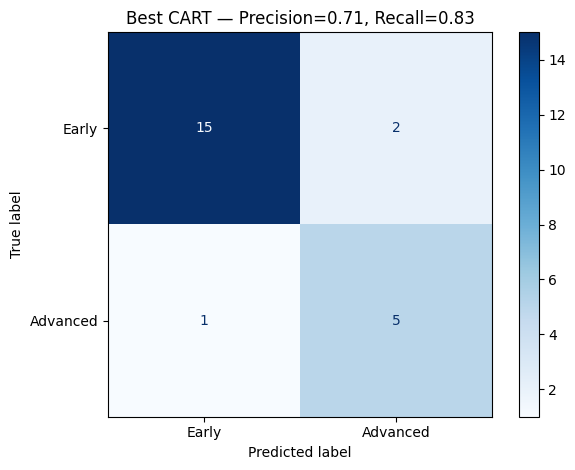


Classification report (Early=0, Advanced=1)
              precision    recall  f1-score   support

       Early      0.938     0.882     0.909        17
    Advanced      0.714     0.833     0.769         6

    accuracy                          0.870        23
   macro avg      0.826     0.858     0.839        23
weighted avg      0.879     0.870     0.873        23



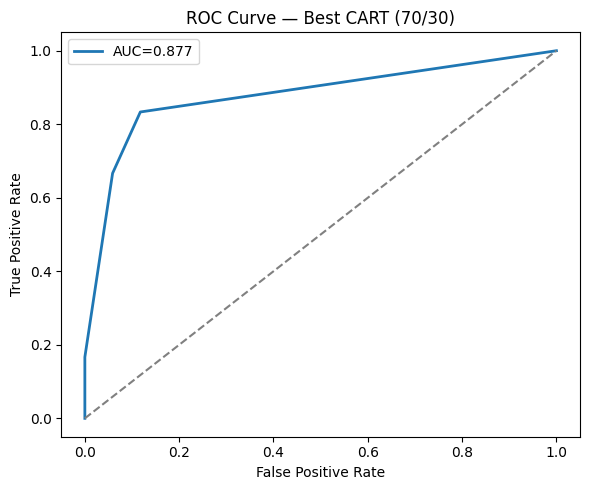

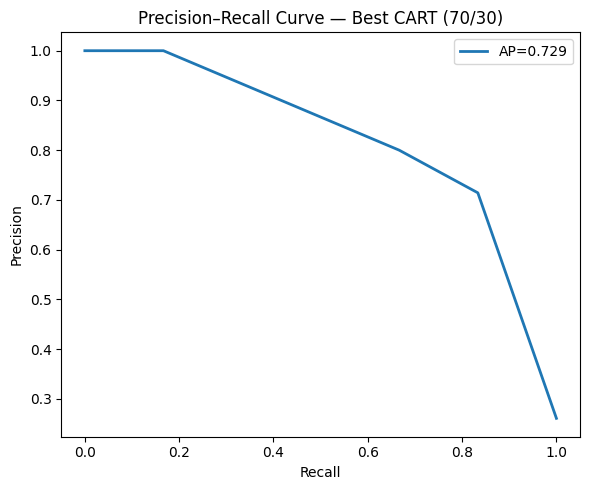

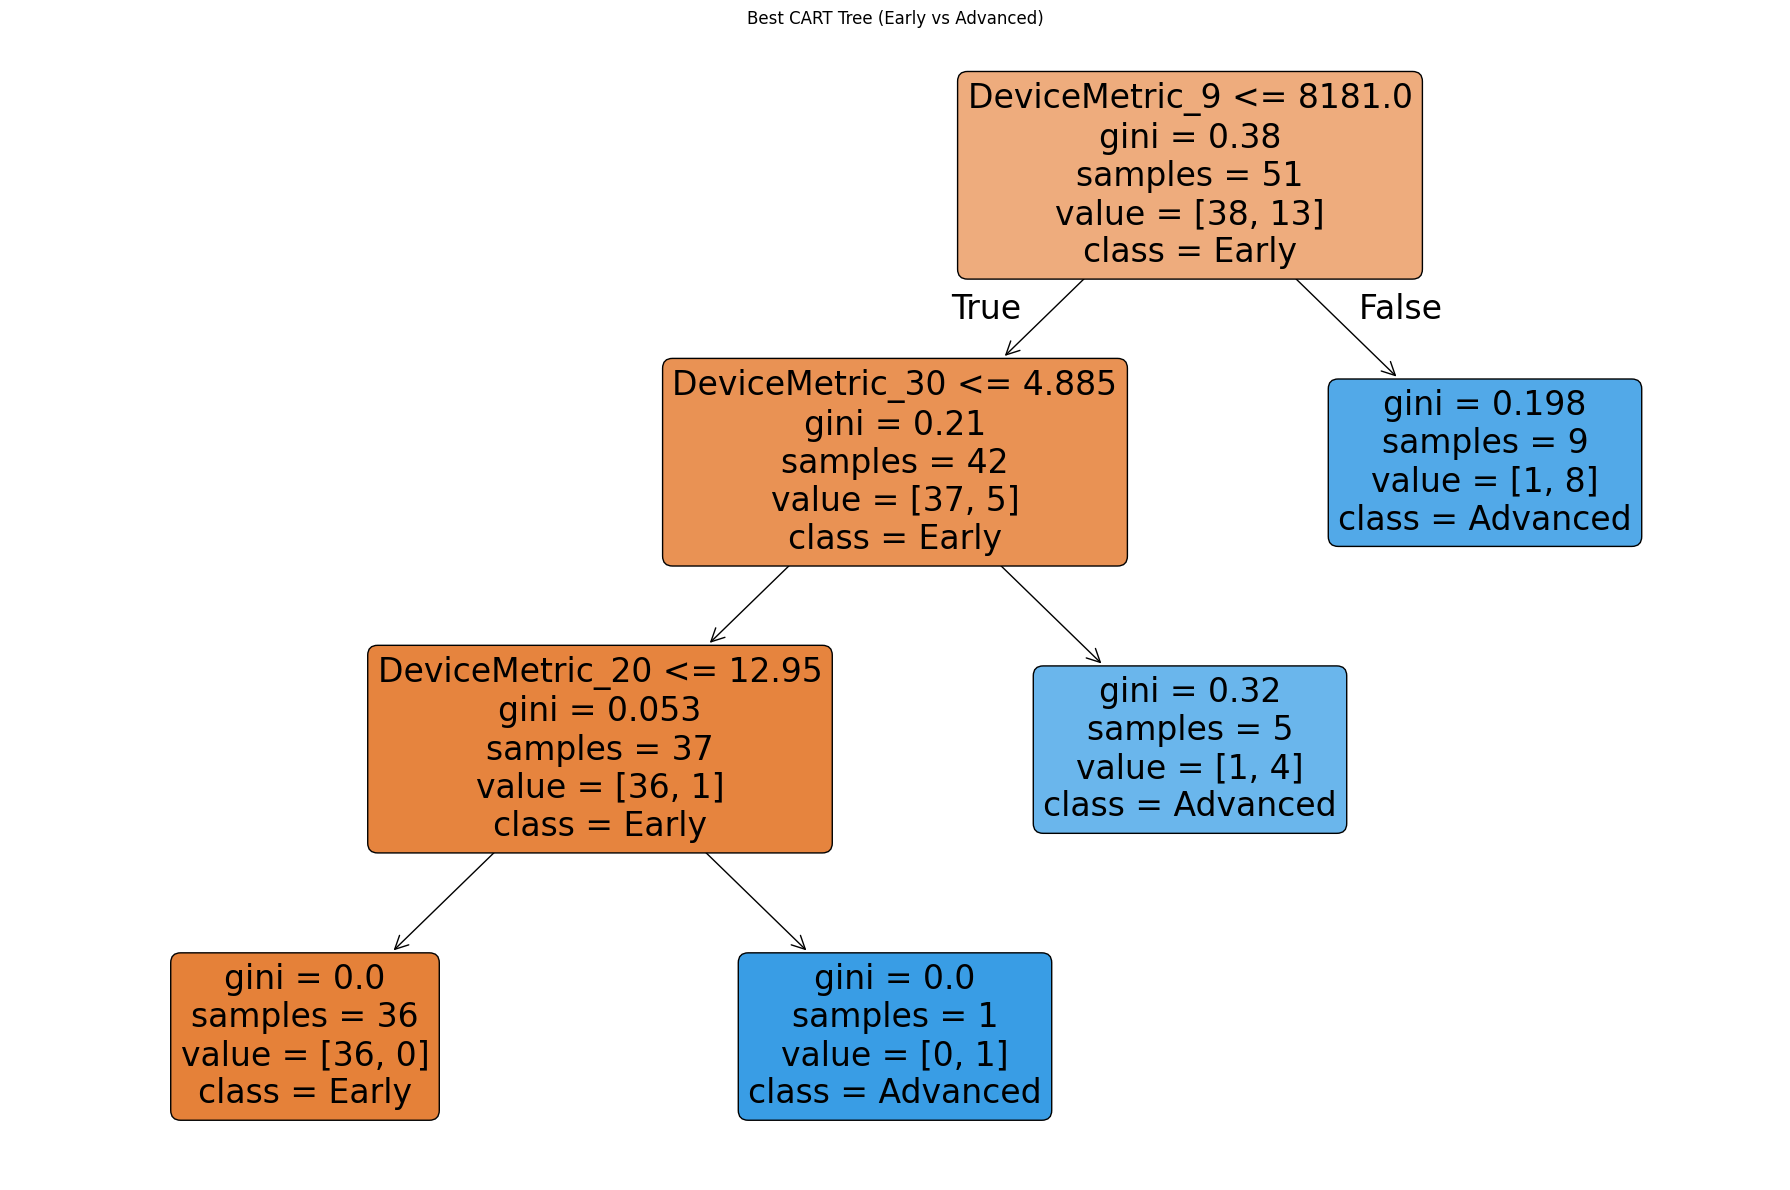


Tree rules (text form, depth<=4):
|--- DeviceMetric_9 <= 8181.00
|   |--- DeviceMetric_30 <= 4.89
|   |   |--- DeviceMetric_20 <= 12.95
|   |   |   |--- class: 0
|   |   |--- DeviceMetric_20 >  12.95
|   |   |   |--- class: 1
|   |--- DeviceMetric_30 >  4.89
|   |   |--- class: 1
|--- DeviceMetric_9 >  8181.00
|   |--- class: 1



In [19]:

# PD STAGING: Early (Stage 1) vs Advanced (Stage 4)
# 70/30 split + hyper parameter grid

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    precision_recall_curve, average_precision_score
)


IN_PATH           = "Parkinsons_vs_Control_Dataset.csv"
RANDOM_STATE      = 42
TEST_SIZE         = 0.30
ROW_NULL_MAX_FRAC = 0.30


df = pd.read_csv(IN_PATH)
df.columns = df.columns.str.strip()
id_col, stage_col = df.columns[0], df.columns[1]

id_numeric = pd.to_numeric(df[id_col], errors="coerce")
idxs = id_numeric.index[id_numeric == 1].tolist()
if not idxs:
    raise ValueError(f"Could not find a row with {id_col} == 1.")
df = df.iloc[idxs[0]:].copy()
df.rename(columns={id_col: "UniqueID", stage_col: "Stage"}, inplace=True)

df["Stage"] = df["Stage"].astype(str).str.strip()
StageNum = pd.to_numeric(df["Stage"], errors="coerce")
df = df.loc[StageNum.isin([1, 4])].copy()
StageNum = StageNum.loc[df.index]
y = np.where(StageNum == 4, 1, 0)

pattern = re.compile(r"^DeviceMetrics?_([1-9]\d*)$")
feature_cols = []
for c in df.columns:
    m = pattern.match(c)
    if m:
        i = int(m.group(1))
        if 1 <= i <= 57:
            feature_cols.append((i, c))
feature_cols = [c for _, c in sorted(feature_cols, key=lambda x: x[0])]
X_df = df[feature_cols].apply(pd.to_numeric, errors="coerce")

row_na_frac = X_df.isna().mean(axis=1)
keep_mask = row_na_frac <= ROW_NULL_MAX_FRAC
X_df = X_df.loc[keep_mask].copy()
y = y[keep_mask.values]

print(f"Target distribution (0=Early, 1=Advanced): {pd.Series(y).value_counts().to_dict()}")
print(f"Final dataset: {X_df.shape[0]} samples, {X_df.shape[1]} features\n")


# Train/Test Split (70/30)

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)


#  parameter grid search

param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5],
    "ccp_alpha": [0.0, 0.0005, 0.001, 0.005],
    "class_weight": [None, "balanced"],
}

best_model = None
best_f1 = -1
best_metrics = {}
best_params = {}

for md, mss, msl, ccp, cw in product(
    param_grid["max_depth"],
    param_grid["min_samples_split"],
    param_grid["min_samples_leaf"],
    param_grid["ccp_alpha"],
    param_grid["class_weight"]
):
    clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", DecisionTreeClassifier(
            criterion="gini",
            splitter="best",
            max_depth=md,
            min_samples_split=mss,
            min_samples_leaf=msl,
            ccp_alpha=ccp,
            class_weight=cw,
            random_state=RANDOM_STATE
        )),
    ])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)

    if f1 > best_f1:
        best_f1 = f1
        best_metrics = {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc_roc, "pr_auc": ap}
        best_params = {"max_depth": md, "min_samples_split": mss, "min_samples_leaf": msl,
                       "ccp_alpha": ccp, "class_weight": cw}
        best_model = clf

print("\n======================")
print("Best Parameters (by F1):")
for k, v in best_params.items():
    print(f"{k}: {v}")
print("\nBest Test Metrics:")
for k, v in best_metrics.items():
    print(f"{k}: {v:.3f}")
print("======================\n")


#  Confusion matrix
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=["Early","Advanced"]).plot(cmap=plt.cm.Blues, colorbar=True)
plt.title(f"Best CART — Precision={best_metrics['prec']:.2f}, Recall={best_metrics['rec']:.2f}")
plt.tight_layout()
plt.show()

#classification report
print("\nClassification report (Early=0, Advanced=1)")
print(classification_report(
    y_test, y_pred_best,
    target_names=["Early","Advanced"],
    digits=3,
    zero_division=0
))

# ROC and Precision–Recall curves

y_proba_best = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Best CART (70/30)")
plt.legend(); plt.tight_layout(); plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_proba_best)
ap = average_precision_score(y_test, y_proba_best)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, lw=2, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Best CART (70/30)")
plt.legend(); plt.tight_layout(); plt.show()


# === Decision tree visualization  ===
tree_clf = best_model.named_steps["clf"]

plt.figure(figsize=(18, 12))
plot_tree(
    tree_clf,
    feature_names=list(feature_cols),
    class_names=["Early","Advanced"],
    filled=True,
    rounded=True,
    impurity=True,         # show Gini
    proportion=False,      # show counts
    max_depth=4
)
plt.title("Best CART Tree (Early vs Advanced)")
plt.tight_layout()
plt.show()


print("\nTree rules (text form, depth<=4):")
print(export_text(tree_clf, feature_names=list(feature_cols), max_depth=4))




Target distribution (0=Early, 1=Advanced): {0: 55, 1: 19}
Final dataset: 74 samples, 57 features


Best Parameters (by F1):
max_depth: 3
min_samples_split: 10
min_samples_leaf: 1
ccp_alpha: 0.0
class_weight: None

Best Test Metrics:
acc: 0.870
prec: 0.714
rec: 0.833
f1: 0.769
auc: 0.877
pr_auc: 0.729


Classification report (Early=0, Advanced=1)
              precision    recall  f1-score   support

       Early      0.938     0.882     0.909        17
    Advanced      0.714     0.833     0.769         6

    accuracy                          0.870        23
   macro avg      0.826     0.858     0.839        23
weighted avg      0.879     0.870     0.873        23



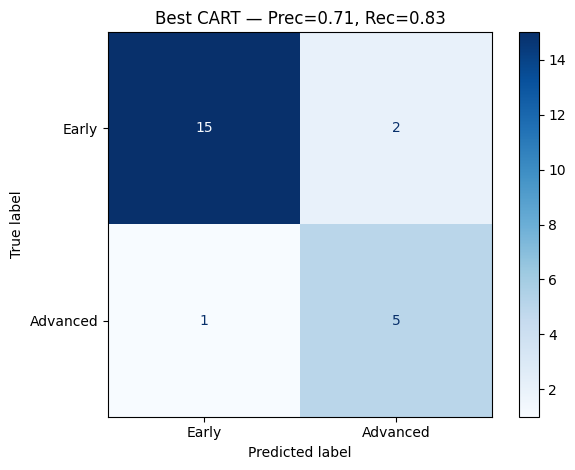

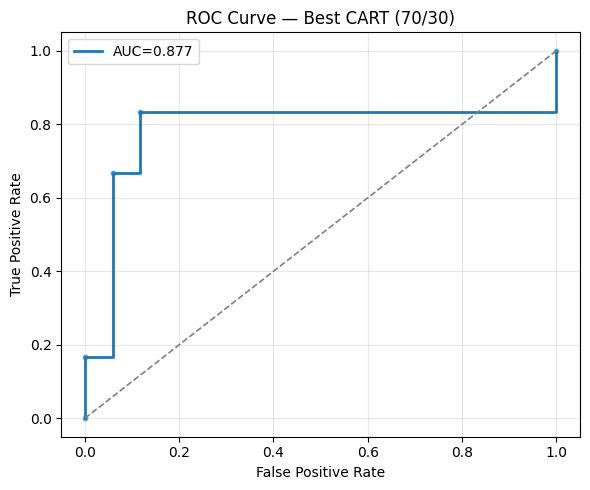

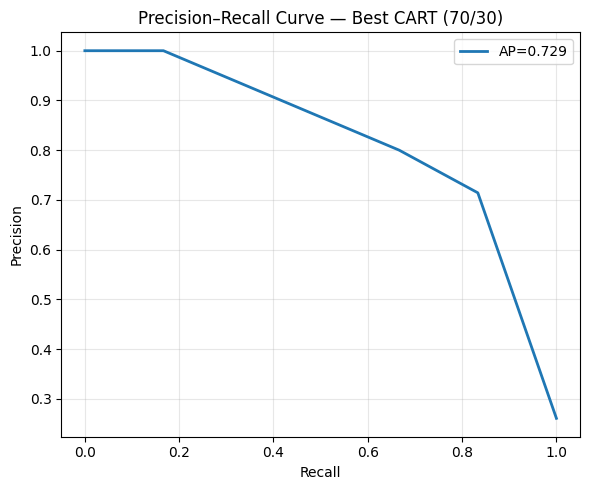

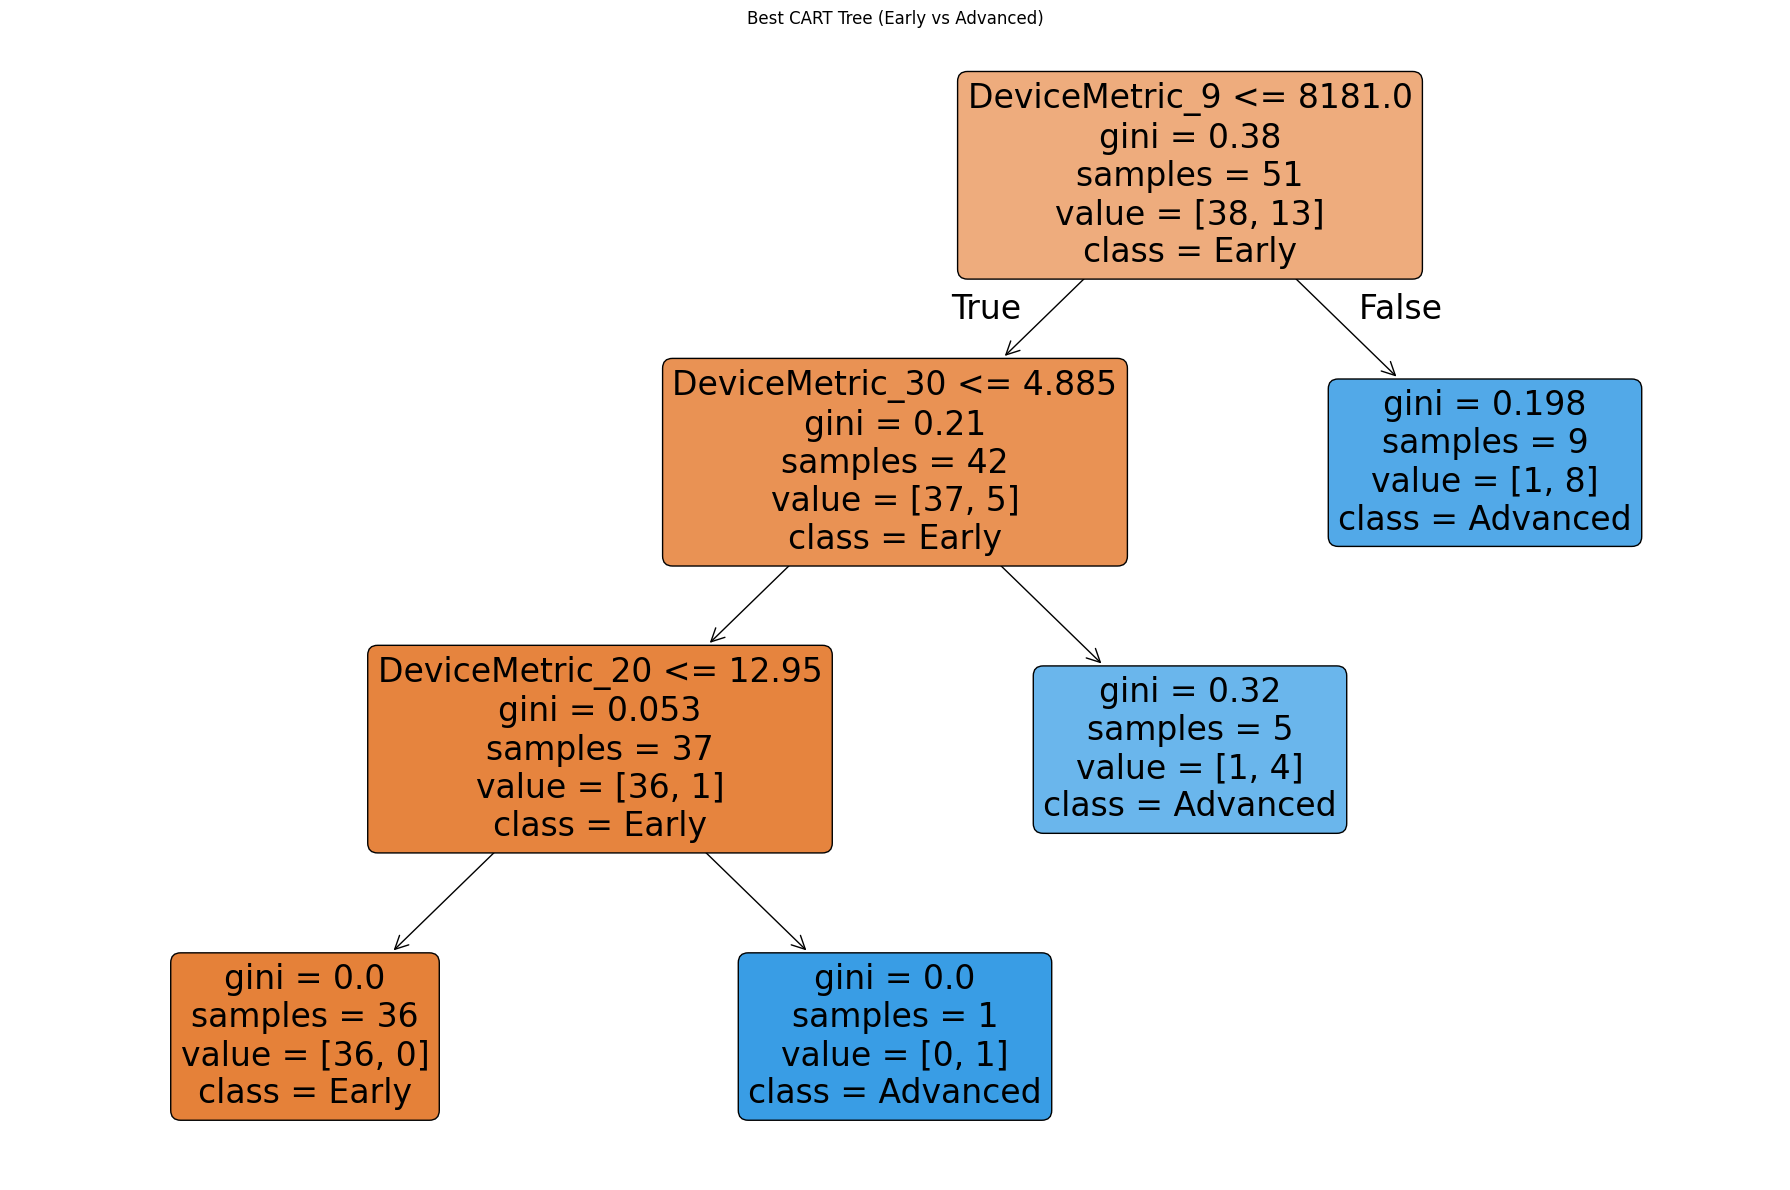


Tree rules (depth <= 4):
|--- DeviceMetric_9 <= 8181.00
|   |--- DeviceMetric_30 <= 4.89
|   |   |--- DeviceMetric_20 <= 12.95
|   |   |   |--- class: 0
|   |   |--- DeviceMetric_20 >  12.95
|   |   |   |--- class: 1
|   |--- DeviceMetric_30 >  4.89
|   |   |--- class: 1
|--- DeviceMetric_9 >  8181.00
|   |--- class: 1


=== Cross-Validation (Stratified K-Fold) ===
Model A: Tuned CART
[Fold 1] AUC=0.750  AP=0.633  (n=15)
[Fold 2] AUC=0.795  AP=0.550  (n=15)
[Fold 3] AUC=0.932  AP=0.733  (n=15)
[Fold 4] AUC=0.432  AP=0.283  (n=15)
[Fold 5] AUC=0.576  AP=0.254  (n=14)

Model B: Baseline CART
[Fold 1] AUC=0.750  AP=0.633  (n=15)
[Fold 2] AUC=0.784  AP=0.517  (n=15)
[Fold 3] AUC=0.955  AP=0.800  (n=15)
[Fold 4] AUC=0.534  AP=0.283  (n=15)
[Fold 5] AUC=0.576  AP=0.254  (n=14)

=== Paired t-test (K-Fold CV) ===
AUROC:
  A folds: [0.75  0.795 0.932 0.432 0.576] | mean=0.697 ± 0.195
  B folds: [0.75  0.784 0.955 0.534 0.576] | mean=0.720 ± 0.170
  t = -1.101, p = 0.3327, d = -0.492
PR-AUC:
  

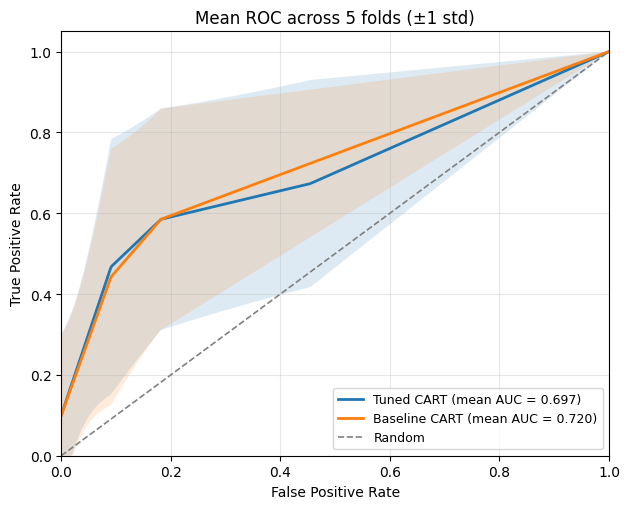

In [21]:

# PD STAGING: Early (Stage 1) vs Advanced (Stage 4)
# 70/30 split + hyperparam grid +K-fold paired t-test

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    precision_recall_curve, average_precision_score, classification_report
)
from scipy.stats import ttest_rel


IN_PATH           = "Parkinsons_vs_Control_Dataset.csv"
RANDOM_STATE      = 42
TEST_SIZE         = 0.30
ROW_NULL_MAX_FRAC = 0.30
CV_SPLITS         = 5
TREE_PLOT_DEPTH   = 4


# keep Stage 1 & 4 only

df = pd.read_csv(IN_PATH)
df.columns = df.columns.str.strip()
id_col, stage_col = df.columns[0], df.columns[1]

# Try to start from UniqueID==1 if present; otherwise just proceed
try:
    id_numeric = pd.to_numeric(df[id_col], errors="coerce")
    idxs = id_numeric.index[id_numeric == 1].tolist()
    if idxs:
        df = df.iloc[idxs[0]:].copy()
except Exception:
    pass

df.rename(columns={id_col: "UniqueID", stage_col: "Stage"}, inplace=True)

df["Stage"] = df["Stage"].astype(str).str.strip()
StageNum = pd.to_numeric(df["Stage"], errors="coerce")

# Keep only Stage 1 (Early) and Stage 4 (Advanced)
df = df.loc[StageNum.isin([1, 4])].copy()
StageNum = StageNum.loc[df.index]
y = np.where(StageNum == 4, 1, 0)  # 1=Advanced, 0=Early

#  Build feature matrix (DeviceMetric_1..DeviceMetric_57)

pattern = re.compile(r"^DeviceMetrics?_([1-9]\d*)$")
feature_cols = []
for c in df.columns:
    m = pattern.match(c)
    if m:
        i = int(m.group(1))
        if 1 <= i <= 57:
            feature_cols.append((i, c))
feature_cols = [c for _, c in sorted(feature_cols, key=lambda x: x[0])]
if not feature_cols:
    raise ValueError("No DeviceMetric_1..DeviceMetric_57 columns found.")

X_df = df[feature_cols].apply(pd.to_numeric, errors="coerce")

# Drop rows too incomplete
row_na_frac = X_df.isna().mean(axis=1)
keep_mask = row_na_frac <= ROW_NULL_MAX_FRAC
X_df = X_df.loc[keep_mask].copy()
y = y[keep_mask.values]

print(f"Target distribution (0=Early, 1=Advanced): {pd.Series(y).value_counts().to_dict()}")
print(f"Final dataset: {X_df.shape[0]} samples, {X_df.shape[1]} features\n")

#Train/Test split (70/30, stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)


# Manual hyperparameter grid search  optimizing F1

param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5],
    "ccp_alpha": [0.0, 0.0005, 0.001, 0.005],
    "class_weight": [None, "balanced"],
}

best_model = None
best_f1 = -1
best_metrics = {}
best_params = {}

for md, mss, msl, ccp, cw in product(
    param_grid["max_depth"],
    param_grid["min_samples_split"],
    param_grid["min_samples_leaf"],
    param_grid["ccp_alpha"],
    param_grid["class_weight"]
):
    clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", DecisionTreeClassifier(
            criterion="gini",
            splitter="best",
            max_depth=md,
            min_samples_split=mss,
            min_samples_leaf=msl,
            ccp_alpha=ccp,
            class_weight=cw,
            random_state=RANDOM_STATE
        )),
    ])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    acc  = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_proba)
    ap   = average_precision_score(y_test, y_proba)

    if f1 > best_f1:
        best_f1 = f1
        best_metrics = {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc_roc, "pr_auc": ap}
        best_params = {"max_depth": md, "min_samples_split": mss, "min_samples_leaf": msl,
                       "ccp_alpha": ccp, "class_weight": cw}
        best_model = clf

print("\n======================")
print("Best Parameters (by F1):")
for k, v in best_params.items():
    print(f"{k}: {v}")
print("\nBest Test Metrics:")
for k, v in best_metrics.items():
    print(f"{k}: {v:.3f}")
print("======================\n")

#  Classification report, confusion matrix, curves, and tree

y_pred_best  = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

print("\nClassification report (Early=0, Advanced=1)")
print(classification_report(
    y_test, y_pred_best,
    target_names=["Early","Advanced"],
    digits=3,
    zero_division=0
))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=["Early","Advanced"]).plot(cmap=plt.cm.Blues, colorbar=True)
plt.title(f"Best CART — Prec={best_metrics['prec']:.2f}, Rec={best_metrics['rec']:.2f}")
plt.tight_layout()
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.step(fpr, tpr, where="post", lw=2, label=f"AUC={roc_auc:.3f}")
plt.scatter(fpr, tpr, s=10, alpha=0.6)
plt.plot([0,1],[0,1],'--',color='gray', lw=1.2)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Best CART (70/30)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# PR
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba_best)
ap = average_precision_score(y_test, y_proba_best)
plt.figure(figsize=(6,5))
plt.plot(recall_vals, precision_vals, lw=2, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Best CART (70/30)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Tree plot
tree_clf = best_model.named_steps["clf"]
plt.figure(figsize=(18, 12))
plot_tree(
    tree_clf,
    feature_names=list(feature_cols),
    class_names=["Early","Advanced"],
    filled=True, rounded=True,
    impurity=True, proportion=False,
    max_depth=TREE_PLOT_DEPTH
)
plt.title("Best CART Tree (Early vs Advanced)")
plt.tight_layout(); plt.show()


print("\nTree rules (depth <= 4):")
print(export_text(tree_clf, feature_names=list(feature_cols), max_depth=TREE_PLOT_DEPTH))

#  K-Fold Cross-Validation + Paired t-test (Tuned CART vs Baseline CART)

def build_pipe_tuned():
    # tuned params discovered above
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", DecisionTreeClassifier(
            criterion="gini",
            splitter="best",
            max_depth=best_params["max_depth"],
            min_samples_split=best_params["min_samples_split"],
            min_samples_leaf=best_params["min_samples_leaf"],
            ccp_alpha=best_params["ccp_alpha"],
            class_weight=best_params["class_weight"],
            random_state=RANDOM_STATE
        )),
    ])

def build_pipe_baseline():
    # simple unpruned baseline
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", DecisionTreeClassifier(
            criterion="gini",
            splitter="best",
            random_state=RANDOM_STATE
        )),
    ])

def evaluate_cv(pipe_builder, X, y, n_splits=CV_SPLITS):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    aucs, aps = [], []
    fpr_grid = np.linspace(0, 1, 501)
    all_tpr = []

    for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y[tr], y[te]

        model = pipe_builder()
        model.fit(X_tr, y_tr)
        y_score = model.predict_proba(X_te)[:, 1]

        # metrics
        aucs.append(roc_auc_score(y_te, y_score))
        aps.append(average_precision_score(y_te, y_score))

        # mean ROC prep
        fpr, tpr, _ = roc_curve(y_te, y_score)
        fpr_u = np.unique(fpr)
        tpr_max = np.array([tpr[fpr == x].max() for x in fpr_u])
        tpr_interp = np.interp(fpr_grid, fpr_u, tpr_max)
        all_tpr.append(tpr_interp)

        print(f"[Fold {fold}] AUC={aucs[-1]:.3f}  AP={aps[-1]:.3f}  (n={len(y_te)})")

    all_tpr = np.vstack(all_tpr)
    return {
        "aucs": np.array(aucs),
        "aps":  np.array(aps),
        "fpr_grid": fpr_grid,
        "mean_tpr": all_tpr.mean(axis=0),
        "std_tpr":  all_tpr.std(axis=0),
    }

print("\n=== Cross-Validation (Stratified K-Fold) ===")
print("Model A: Tuned CART")
res_a = evaluate_cv(build_pipe_tuned, X_df, y, n_splits=CV_SPLITS)

print("\nModel B: Baseline CART")
res_b = evaluate_cv(build_pipe_baseline, X_df, y, n_splits=CV_SPLITS)

# Paired t-tests
def safe_ttest_rel(a, b):
    t_val, p_val = ttest_rel(a, b)
    if np.isnan(t_val) or np.isnan(p_val):
        return 0.0, 1.0
    return t_val, p_val

t_auc, p_auc = safe_ttest_rel(res_a["aucs"], res_b["aucs"])
t_ap,  p_ap  = safe_ttest_rel(res_a["aps"],  res_b["aps"])

def paired_cohens_d(a, b):
    diff = a - b
    sd = diff.std(ddof=1)
    return 0.0 if sd == 0 else diff.mean() / (sd + 1e-12)

d_auc = paired_cohens_d(res_a["aucs"], res_b["aucs"])
d_ap  = paired_cohens_d(res_a["aps"],  res_b["aps"])

print("\n=== Paired t-test (K-Fold CV) ===")
print("AUROC:")
print(f"  A folds: {np.round(res_a['aucs'],3)} | mean={res_a['aucs'].mean():.3f} ± {res_a['aucs'].std(ddof=1):.3f}")
print(f"  B folds: {np.round(res_b['aucs'],3)} | mean={res_b['aucs'].mean():.3f} ± {res_b['aucs'].std(ddof=1):.3f}")
print(f"  t = {t_auc:.3f}, p = {p_auc:.4f}, d = {d_auc:.3f}")

print("PR-AUC:")
print(f"  A folds: {np.round(res_a['aps'],3)} | mean={res_a['aps'].mean():.3f} ± {res_a['aps'].std(ddof=1):.3f}")
print(f"  B folds: {np.round(res_b['aps'],3)} | mean={res_b['aps'].mean():.3f} ± {res_b['aps'].std(ddof=1):.3f}")
print(f"  t = {t_ap:.3f}, p = {p_ap:.4f}, d = {d_ap:.3f}")

# Mean ROC plot with ±1 std for both models
plt.figure(figsize=(6.4, 5.2))
for label, res in [("Tuned CART", res_a), ("Baseline CART", res_b)]:
    fpr_grid, mean_tpr, std_tpr = res["fpr_grid"], res["mean_tpr"], res["std_tpr"]
    mean_auc = res["aucs"].mean()
    plt.plot(fpr_grid, mean_tpr, lw=2, label=f"{label} (mean AUC = {mean_auc:.3f})")
    plt.fill_between(fpr_grid,
                     np.clip(mean_tpr - std_tpr, 0, 1),
                     np.clip(mean_tpr + std_tpr, 0, 1),
                     alpha=0.15)
plt.plot([0,1],[0,1],"--",color="gray", lw=1.2, label="Random")
plt.xlim(0,1); plt.ylim(0,1.05)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"Mean ROC across {CV_SPLITS} folds (±1 std)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


# Categorized PD staging

Target distribution (0=Early, 1=Advanced): {0: 55, 1: 19}
Dataset: 74 samples, 57 features

Feature counts by category:
  executive function: 4 features
  memory: 3 features
  motor: 39 features
  speech: 11 features

Hyperparameter grid: 360 combinations per category

CATEGORY: EXECUTIVE FUNCTION
Using 4 features from 'executive function' category

Best Hyperparameters (by F1):
  max_depth: 3
  min_samples_split: 2
  min_samples_leaf: 5
  ccp_alpha: 0.0
  class_weight: balanced

Test Set Metrics:
  Accuracy : 0.6087
  Precision: 0.3333
  Recall   : 0.5000
  F1-score : 0.4000
  AUROC    : 0.5539

Classification Report:
                precision    recall  f1-score   support

   Early Stage      0.786     0.647     0.710        17
Advanced Stage      0.333     0.500     0.400         6

      accuracy                          0.609        23
     macro avg      0.560     0.574     0.555        23
  weighted avg      0.668     0.609     0.629        23

Confusion Matrix:
                

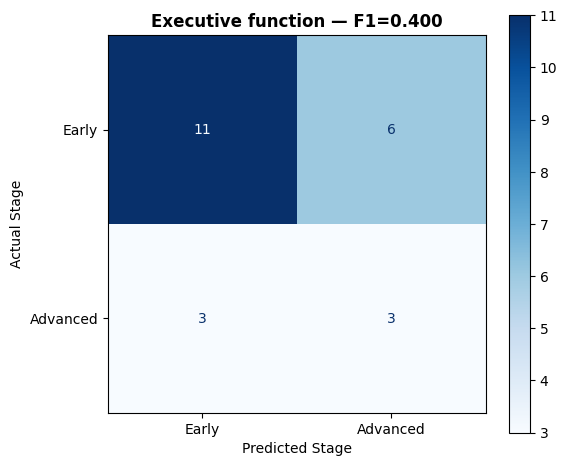

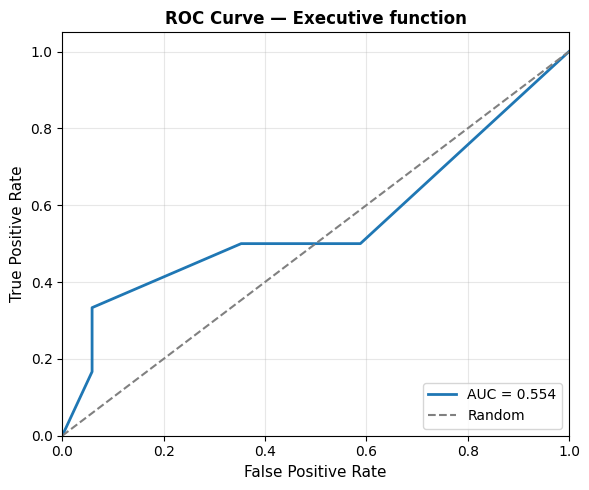

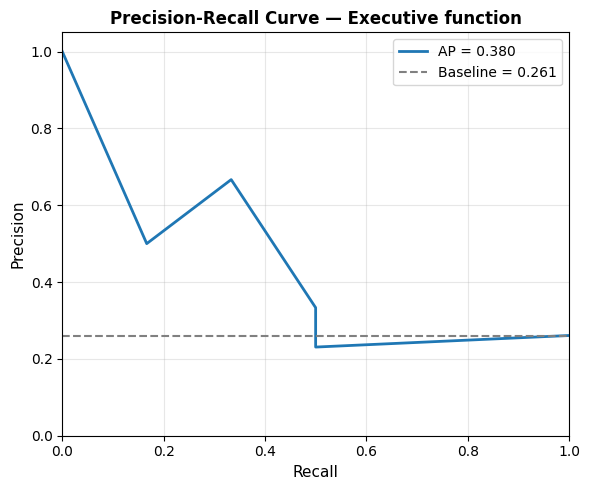


CATEGORY: MEMORY
Using 3 features from 'memory' category

Best Hyperparameters (by F1):
  max_depth: 5
  min_samples_split: 2
  min_samples_leaf: 1
  ccp_alpha: 0.0
  class_weight: balanced

Test Set Metrics:
  Accuracy : 0.7826
  Precision: 0.6000
  Recall   : 0.5000
  F1-score : 0.5455
  AUROC    : 0.6618

Classification Report:
                precision    recall  f1-score   support

   Early Stage      0.833     0.882     0.857        17
Advanced Stage      0.600     0.500     0.545         6

      accuracy                          0.783        23
     macro avg      0.717     0.691     0.701        23
  weighted avg      0.772     0.783     0.776        23

Confusion Matrix:
                  Pred: Early  Pred: Advanced
Actual: Early              15               2
Actual: Advanced            3               3


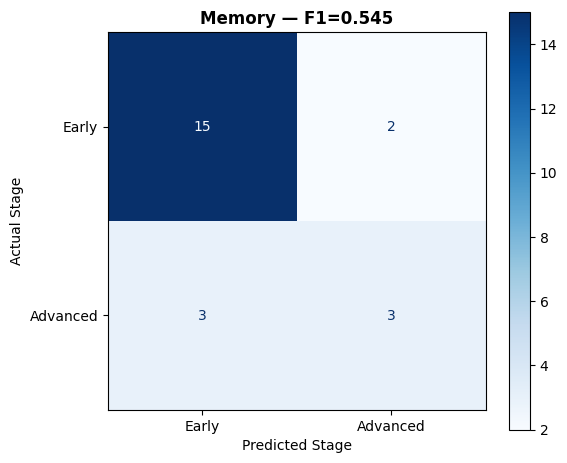

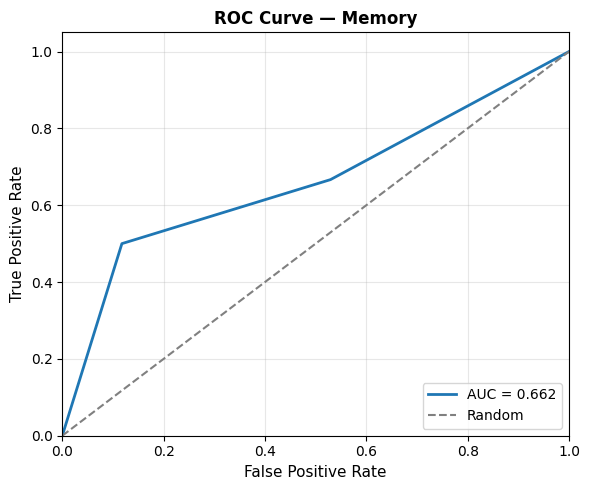

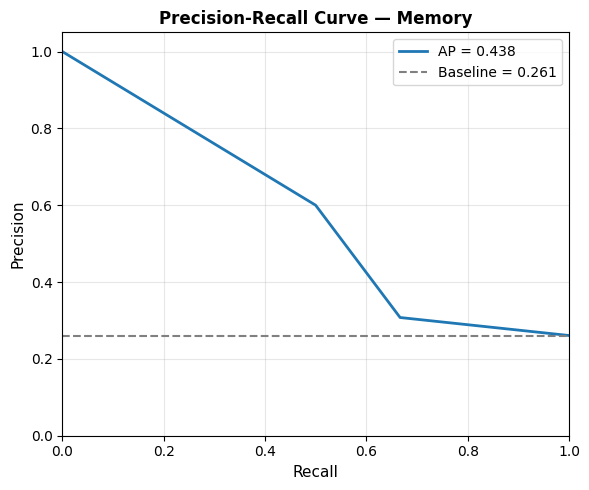


CATEGORY: MOTOR
Using 39 features from 'motor' category

Best Hyperparameters (by F1):
  max_depth: 3
  min_samples_split: 2
  min_samples_leaf: 3
  ccp_alpha: 0.0
  class_weight: None

Test Set Metrics:
  Accuracy : 0.8696
  Precision: 0.7143
  Recall   : 0.8333
  F1-score : 0.7692
  AUROC    : 0.8480

Classification Report:
                precision    recall  f1-score   support

   Early Stage      0.938     0.882     0.909        17
Advanced Stage      0.714     0.833     0.769         6

      accuracy                          0.870        23
     macro avg      0.826     0.858     0.839        23
  weighted avg      0.879     0.870     0.873        23

Confusion Matrix:
                  Pred: Early  Pred: Advanced
Actual: Early              15               2
Actual: Advanced            1               5


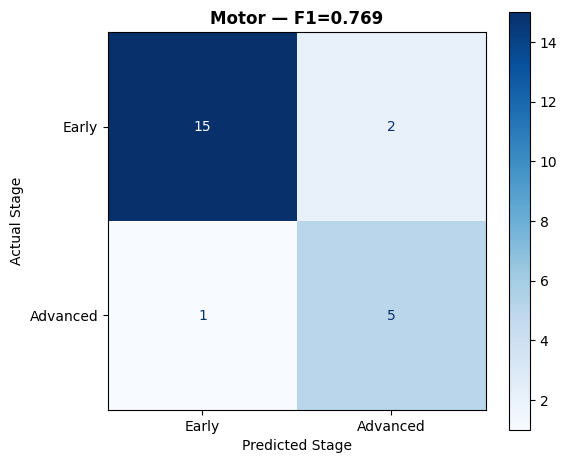

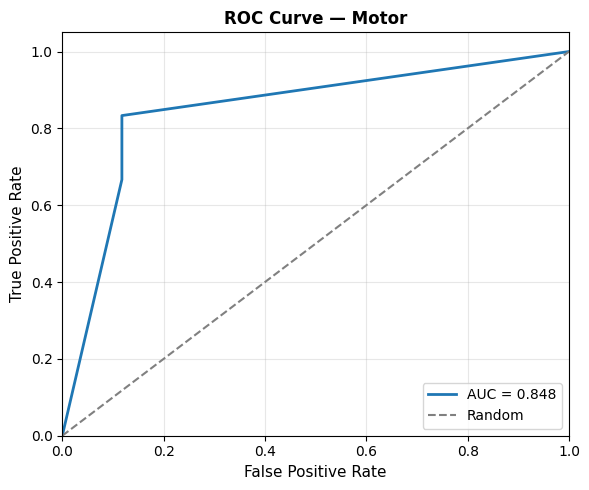

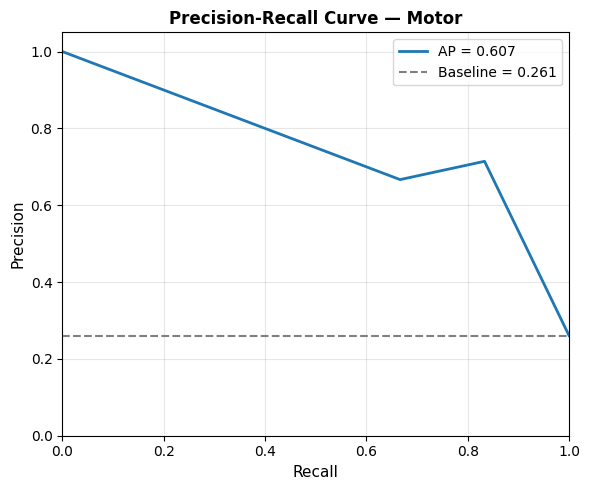


CATEGORY: SPEECH
Using 11 features from 'speech' category

Best Hyperparameters (by F1):
  max_depth: 3
  min_samples_split: 5
  min_samples_leaf: 1
  ccp_alpha: 0.0
  class_weight: None

Test Set Metrics:
  Accuracy : 0.7826
  Precision: 0.6000
  Recall   : 0.5000
  F1-score : 0.5455
  AUROC    : 0.7402

Classification Report:
                precision    recall  f1-score   support

   Early Stage      0.833     0.882     0.857        17
Advanced Stage      0.600     0.500     0.545         6

      accuracy                          0.783        23
     macro avg      0.717     0.691     0.701        23
  weighted avg      0.772     0.783     0.776        23

Confusion Matrix:
                  Pred: Early  Pred: Advanced
Actual: Early              15               2
Actual: Advanced            3               3


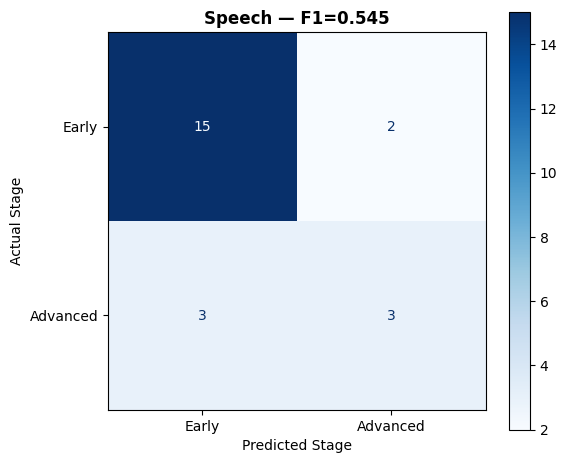

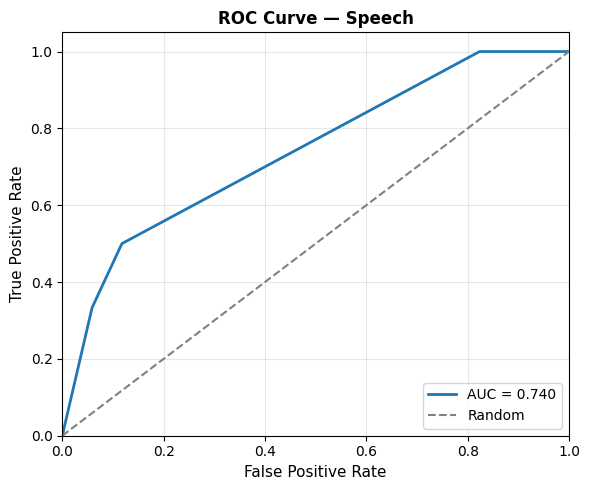

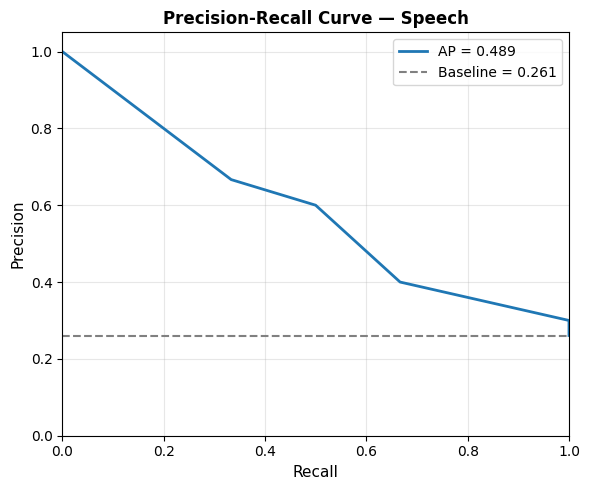



SUMMARY: Early vs Advanced PD Staging by Cognitive Category
Assessment/function  Accuracy  Precision  Recall     F1  AUROC  N_features
              Motor    0.8696     0.7143  0.8333 0.7692 0.8480          39
             Memory    0.7826     0.6000  0.5000 0.5455 0.6618           3
             Speech    0.7826     0.6000  0.5000 0.5455 0.7402          11
 Executive function    0.6087     0.3333  0.5000 0.4000 0.5539           4



In [24]:

# PD STAGING (Early vs Advanced): Category-wise Analysis
# Separate models for Motor, Memory, Speech, Executive Function

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    precision_recall_curve, average_precision_score, classification_report
)


DATA_PATH     = "Parkinsons_vs_Control_Dataset.csv"
CATEGORY_PATH = "feature_description_modified.csv"
RANDOM_STATE  = 42
TEST_SIZE     = 0.30
ROW_NULL_MAX_FRAC = 0.30

# Load Feature Categories

cat_df = pd.read_csv(CATEGORY_PATH)
cat_df.columns = cat_df.columns.str.strip()
cat_df['Feature'] = cat_df['Feature'].str.strip()
cat_df['Category'] = cat_df['Category'].str.strip()

feature_to_category = dict(zip(cat_df['Feature'], cat_df['Category']))

#  Load Main Dataset (Stage 1 & 4 only)

df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()
id_col, stage_col = df.columns[0], df.columns[1]

# Start from UniqueID == 1
id_numeric = pd.to_numeric(df[id_col], errors="coerce")
idxs = id_numeric.index[id_numeric == 1].tolist()
if not idxs:
    raise ValueError(f"Could not find a row with {id_col} == 1.")
df = df.iloc[idxs[0]:].copy()

df.rename(columns={id_col: "UniqueID", stage_col: "Stage"}, inplace=True)

# Filter: Keep ONLY Stage 1 (Early) and Stage 4 (Advanced)
df["Stage"] = df["Stage"].astype(str).str.strip()
StageNum = pd.to_numeric(df["Stage"], errors="coerce")
df = df.loc[StageNum.isin([1, 4])].copy()
StageNum = StageNum.loc[df.index]

# Binary target: 0 = Early (Stage 1), 1 = Advanced (Stage 4)
y = np.where(StageNum == 4, 1, 0)
print(f"Target distribution (0=Early, 1=Advanced): {pd.Series(y).value_counts().to_dict()}")

# Collect all features
pattern = re.compile(r"^DeviceMetrics?_([1-9]\d*)$")
feature_cols = []
for c in df.columns:
    m = pattern.match(c)
    if m:
        idx = int(m.group(1))
        if 1 <= idx <= 57:
            feature_cols.append((idx, c))
feature_cols = [c for _, c in sorted(feature_cols, key=lambda x: x[0])]

X_df = df[feature_cols].apply(pd.to_numeric, errors="coerce")

# Drop rows with too many missing features
row_na_frac = X_df.isna().mean(axis=1)
keep_mask = row_na_frac <= ROW_NULL_MAX_FRAC
X_df = X_df.loc[keep_mask].copy()
y = y[keep_mask.values]

print(f"Dataset: {X_df.shape[0]} samples, {X_df.shape[1]} features\n")

# Organize Features by Category

categories = {}
for feat in feature_cols:
    cat = feature_to_category.get(feat, 'unknown')
    if cat not in categories:
        categories[cat] = []
    categories[cat].append(feat)

if 'unknown' in categories:
    del categories['unknown']

print("Feature counts by category:")
for cat, feats in sorted(categories.items()):
    print(f"  {cat}: {len(feats)} features")
print()

#  Hyperparameter Grid

param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5],
    "ccp_alpha": [0.0, 0.0005, 0.001, 0.005],
    "class_weight": [None, "balanced"],
}

total_combos = 1
for values in param_grid.values():
    total_combos *= len(values)

print(f"Hyperparameter grid: {total_combos} combinations per category\n")

# Train & Evaluate for Each Category

results_summary = []

for category_name in sorted(categories.keys()):
    print(f"{'='*70}")
    print(f"CATEGORY: {category_name.upper()}")
    print(f"{'='*70}")

    # Select features for this category
    cat_features = categories[category_name]
    X_cat = X_df[cat_features].copy()

    print(f"Using {len(cat_features)} features from '{category_name}' category")

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_cat, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )

    # Manual grid search
    best_model = None
    best_f1 = -1
    best_metrics = {}
    best_params = {}

    for md, mss, msl, ccp, cw in product(
        param_grid["max_depth"],
        param_grid["min_samples_split"],
        param_grid["min_samples_leaf"],
        param_grid["ccp_alpha"],
        param_grid["class_weight"]
    ):
        clf = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("clf", DecisionTreeClassifier(
                criterion="gini",
                splitter="best",
                max_depth=md,
                min_samples_split=mss,
                min_samples_leaf=msl,
                ccp_alpha=ccp,
                class_weight=cw,
                random_state=RANDOM_STATE
            )),
        ])

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)[:, 1]

        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        acc = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_proba)

        if f1 > best_f1:
            best_f1 = f1
            best_metrics = {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc_roc}
            best_params = {"max_depth": md, "min_samples_split": mss, "min_samples_leaf": msl,
                           "ccp_alpha": ccp, "class_weight": cw}
            best_model = clf

    # Store results
    results_summary.append({
        'Assessment/function': category_name.capitalize(),
        'Accuracy': best_metrics['acc'],
        'Precision': best_metrics['prec'],
        'Recall': best_metrics['rec'],
        'F1': best_metrics['f1'],
        'AUROC': best_metrics['auc'],
        'N_features': len(cat_features)
    })

    # Print best params and metrics
    print(f"\nBest Hyperparameters (by F1):")
    for k, v in best_params.items():
        print(f"  {k}: {v}")

    print(f"\nTest Set Metrics:")
    print(f"  Accuracy : {best_metrics['acc']:.4f}")
    print(f"  Precision: {best_metrics['prec']:.4f}")
    print(f"  Recall   : {best_metrics['rec']:.4f}")
    print(f"  F1-score : {best_metrics['f1']:.4f}")
    print(f"  AUROC    : {best_metrics['auc']:.4f}")

    # Classification Report
    y_pred_best = best_model.predict(X_test)
    print(f"\nClassification Report:")
    print(classification_report(
        y_test, y_pred_best,
        target_names=["Early Stage", "Advanced Stage"],
        zero_division=0,
        digits=3
    ))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_best, labels=[0, 1])
    cm_df = pd.DataFrame(cm,
        index=["Actual: Early", "Actual: Advanced"],
        columns=["Pred: Early", "Pred: Advanced"]
    )
    print("Confusion Matrix:")
    print(cm_df)

    # Plot Confusion Matrix
    fig = plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Early", "Advanced"])
    ax = plt.gca()
    disp.plot(values_format="d", cmap=plt.cm.Blues, colorbar=True, ax=ax)
    plt.title(f"{category_name.capitalize()} — F1={best_metrics['f1']:.3f}",
              fontsize=12, fontweight='bold')
    plt.xlabel("Predicted Stage", fontsize=10)
    plt.ylabel("Actual Stage", fontsize=10)
    plt.tight_layout()
    plt.show()

    # ROC Curve
    y_proba_best = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba_best)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='#1f77b4', lw=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.title(f'ROC Curve — {category_name.capitalize()}', fontsize=12, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba_best)
    avg_precision = average_precision_score(y_test, y_proba_best)

    plt.figure(figsize=(6, 5))
    plt.plot(recall_vals, precision_vals, color='#1f77b4', lw=2,
             label=f'AP = {avg_precision:.3f}')
    baseline = y_test.sum() / len(y_test)
    plt.plot([0, 1], [baseline, baseline], color='gray', lw=1.5,
             linestyle='--', label=f'Baseline = {baseline:.3f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=11)
    plt.ylabel('Precision', fontsize=11)
    plt.title(f'Precision-Recall Curve — {category_name.capitalize()}',
              fontsize=12, fontweight='bold')
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print()

# Summary Table

results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('F1', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("SUMMARY: Early vs Advanced PD Staging by Cognitive Category")
print("="*80)
print(results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print()



used multiple random states

In [23]:
# =========================
# PD STAGING (Early vs Advanced): Category-wise with Multiple Random States
# =========================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

DATA_PATH     = "Parkinsons_vs_Control_Dataset.csv"
CATEGORY_PATH = "feature_description_modified.csv"
RANDOM_STATES = [0, 42, 123, 456, 789]  # 5 random states for stability
TEST_SIZE     = 0.30
ROW_NULL_MAX_FRAC = 0.30


cat_df = pd.read_csv(CATEGORY_PATH)
cat_df.columns = cat_df.columns.str.strip()
cat_df['Feature'] = cat_df['Feature'].str.strip()
cat_df['Category'] = cat_df['Category'].str.strip()

feature_to_category = dict(zip(cat_df['Feature'], cat_df['Category']))

# (Stage 1 & 4 only)

df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()
id_col, stage_col = df.columns[0], df.columns[1]

id_numeric = pd.to_numeric(df[id_col], errors="coerce")
idxs = id_numeric.index[id_numeric == 1].tolist()
if not idxs:
    raise ValueError(f"Could not find a row with {id_col} == 1.")
df = df.iloc[idxs[0]:].copy()

df.rename(columns={id_col: "UniqueID", stage_col: "Stage"}, inplace=True)

df["Stage"] = df["Stage"].astype(str).str.strip()
StageNum = pd.to_numeric(df["Stage"], errors="coerce")
df = df.loc[StageNum.isin([1, 4])].copy()
StageNum = StageNum.loc[df.index]

y = np.where(StageNum == 4, 1, 0)
print(f"Target distribution (0=Early, 1=Advanced): {pd.Series(y).value_counts().to_dict()}")

# Collect all features
pattern = re.compile(r"^DeviceMetrics?_([1-9]\d*)$")
feature_cols = []
for c in df.columns:
    m = pattern.match(c)
    if m:
        idx = int(m.group(1))
        if 1 <= idx <= 57:
            feature_cols.append((idx, c))
feature_cols = [c for _, c in sorted(feature_cols, key=lambda x: x[0])]

X_df = df[feature_cols].apply(pd.to_numeric, errors="coerce")

row_na_frac = X_df.isna().mean(axis=1)
keep_mask = row_na_frac <= ROW_NULL_MAX_FRAC
X_df = X_df.loc[keep_mask].copy()
y = y[keep_mask.values]

print(f"Dataset: {X_df.shape[0]} samples, {X_df.shape[1]} features")
print(f"⚠️  WARNING: Small dataset for staging task!\n")

# Organize Features by Category

categories = {}
for feat in feature_cols:
    cat = feature_to_category.get(feat, 'unknown')
    if cat not in categories:
        categories[cat] = []
    categories[cat].append(feat)

if 'unknown' in categories:
    del categories['unknown']

print("Feature counts by category:")
for cat, feats in sorted(categories.items()):
    print(f"  {cat}: {len(feats)} features")
print()

# Hyperparameter Grid (smaller for speed with multiple RS)

param_grid = {
    "max_depth": [5, 7, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "ccp_alpha": [0.0, 0.001],
    "class_weight": [None, "balanced"],
}

# Train for Each Category Across Multiple Random States

all_category_results = []

for category_name in sorted(categories.keys()):
    print(f"{'='*70}")
    print(f"CATEGORY: {category_name.upper()}")
    print(f"{'='*70}")

    cat_features = categories[category_name]
    X_cat = X_df[cat_features].copy()

    print(f"Using {len(cat_features)} features")

    # Store results for each random state
    rs_results = []

    for rs_idx, rs in enumerate(RANDOM_STATES, 1):
        print(f"  Random State {rs_idx}/5: {rs}...", end=" ")

        # Train/Test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_cat, y, test_size=TEST_SIZE, stratify=y, random_state=rs
        )

        # Manual grid search for this RS
        best_f1 = -1
        best_metrics = {}

        for md, mss, msl, ccp, cw in product(
            param_grid["max_depth"],
            param_grid["min_samples_split"],
            param_grid["min_samples_leaf"],
            param_grid["ccp_alpha"],
            param_grid["class_weight"]
        ):
            clf = Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("clf", DecisionTreeClassifier(
                    criterion="gini",
                    max_depth=md,
                    min_samples_split=mss,
                    min_samples_leaf=msl,
                    ccp_alpha=ccp,
                    class_weight=cw,
                    random_state=rs
                )),
            ])

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_proba = clf.predict_proba(X_test)[:, 1]

            f1 = f1_score(y_test, y_pred, zero_division=0)

            if f1 > best_f1:
                best_f1 = f1
                best_metrics = {
                    "acc": accuracy_score(y_test, y_pred),
                    "prec": precision_score(y_test, y_pred, zero_division=0),
                    "rec": recall_score(y_test, y_pred, zero_division=0),
                    "f1": f1,
                    "auc": roc_auc_score(y_test, y_proba)
                }

        rs_results.append(best_metrics)
        print(f"F1={best_metrics['f1']:.3f}")

    # Calculate mean ± std across random states
    metrics_mean = {
        'acc': np.mean([r['acc'] for r in rs_results]),
        'prec': np.mean([r['prec'] for r in rs_results]),
        'rec': np.mean([r['rec'] for r in rs_results]),
        'f1': np.mean([r['f1'] for r in rs_results]),
        'auc': np.mean([r['auc'] for r in rs_results])
    }

    metrics_std = {
        'acc': np.std([r['acc'] for r in rs_results]),
        'prec': np.std([r['prec'] for r in rs_results]),
        'rec': np.std([r['rec'] for r in rs_results]),
        'f1': np.std([r['f1'] for r in rs_results]),
        'auc': np.std([r['auc'] for r in rs_results])
    }

    print(f"\n  Aggregate Results (Mean ± Std):")
    print(f"    Accuracy : {metrics_mean['acc']:.3f} ± {metrics_std['acc']:.3f}")
    print(f"    Precision: {metrics_mean['prec']:.3f} ± {metrics_std['prec']:.3f}")
    print(f"    Recall   : {metrics_mean['rec']:.3f} ± {metrics_std['rec']:.3f}")
    print(f"    F1-score : {metrics_mean['f1']:.3f} ± {metrics_std['f1']:.3f}")
    print(f"    AUROC    : {metrics_mean['auc']:.3f} ± {metrics_std['auc']:.3f}")

    all_category_results.append({
        'Assessment/function': category_name.capitalize(),
        'Accuracy': f"{metrics_mean['acc']:.3f}±{metrics_std['acc']:.3f}",
        'Precision': f"{metrics_mean['prec']:.3f}±{metrics_std['prec']:.3f}",
        'Recall': f"{metrics_mean['rec']:.3f}±{metrics_std['rec']:.3f}",
        'F1': f"{metrics_mean['f1']:.3f}±{metrics_std['f1']:.3f}",
        'AUROC': f"{metrics_mean['auc']:.3f}±{metrics_std['auc']:.3f}",
        'N_features': len(cat_features),
        'f1_mean_sort': metrics_mean['f1']  # For sorting
    })

    print()

# Summary Table

results_df = pd.DataFrame(all_category_results)
results_df = results_df.sort_values('f1_mean_sort', ascending=False).reset_index(drop=True)
results_df = results_df.drop('f1_mean_sort', axis=1)

print("\n" + "="*100)
print("SUMMARY: Early vs Advanced PD Staging by Cognitive Category (Mean ± Std)")
print("="*100)
print(results_df.to_string(index=False))
print()



Target distribution (0=Early, 1=Advanced): {0: 55, 1: 19}
Dataset: 74 samples, 57 features
⚠️  WARNING: Small dataset for staging task!

Feature counts by category:
  executive function: 4 features
  memory: 3 features
  motor: 39 features
  speech: 11 features

CATEGORY: EXECUTIVE FUNCTION
Using 4 features
  Random State 1/5: 0... F1=0.600
  Random State 2/5: 42... F1=0.364
  Random State 3/5: 123... F1=0.308
  Random State 4/5: 456... F1=0.500
  Random State 5/5: 789... F1=0.444

  Aggregate Results (Mean ± Std):
    Accuracy : 0.730 ± 0.075
    Precision: 0.520 ± 0.170
    Recall   : 0.400 ± 0.082
    F1-score : 0.443 ± 0.102
    AUROC    : 0.598 ± 0.072

CATEGORY: MEMORY
Using 3 features
  Random State 1/5: 0... F1=0.222
  Random State 2/5: 42... F1=0.545
  Random State 3/5: 123... F1=0.833
  Random State 4/5: 456... F1=0.545
  Random State 5/5: 789... F1=0.500

  Aggregate Results (Mean ± Std):
    Accuracy : 0.783 ± 0.073
    Precision: 0.573 ± 0.162
    Recall   : 0.500 ± 0.211
